In [3]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm 
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torchinfo

from pycaleva import CalibrationEvaluator
from scipy.stats import chi2

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pickle
from utils import augmentation as aug

In [4]:
def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [5]:
def prepareData(dataGroup, id_list, window_time):
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
    elif dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):
        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")

        # 0 --> HR
        # 1 --> SpO2
        # 2 --> PAD
        # 3 --> PAM
        # 4 --> PAS
        # 5 --> RR
        # 6 --> Temperature
        # 7 --> Diuresis
        # 8 --> SpO2/FiO2
        # 9 --> FiO2
        # 10 --> ECMO flow
        
        # idx_variables_kept = [0,1,3,4,6,7]
        if dataGroup == "dataECMO":
            # idx_variables_kept = [0,1,2,3,4,5,6,7,8,9]
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]
        else:
            idx_variables_kept = [0,1,2,3,4,5,6,7,8]

        data_patient = df_dynamic.iloc[:(window_time*24), idx_variables_kept].to_numpy()
        
        for value in df_static.to_numpy()[0]:
            new_column = np.ones(shape=(window_time*24,1)) * value
            data_patient = np.append(data_patient, new_column, axis=1)
        
        # df_dynamic_masked = df_dynamic.iloc[:(window_time*24)].mask(df_mask.iloc[:(window_time*24)] == 0)

        # # idx_variables_kept = [0,1,3,4,6,7]
        # idx_variables_kept = list(range(0,10))
        # df_dynamic_masked = df_dynamic_masked.iloc[:,idx_variables_kept]
        # df_dynamic = df_dynamic.iloc[:,idx_variables_kept]


        data.append(data_patient)
    
    return np.array(data)


def prepareDeathList(dataGroup, window_time):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        patients_df = pd.read_csv(dataPath + "ventiles.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])

            df_mask = pd.read_parquet(dataPath + "finalData/" + stay_id + "/mask.parquet")
            total_true_values = df_mask.values.sum()
            total_values = df_mask.values.size
            percentageMissingValues = (total_values-total_true_values)/total_values * 100

            if percentageMissingValues < 40:
                id_list.append(stay_id)
                
                label_death = int(row["label"])
                target.append(label_death)
            
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    elif dataGroup == "dataRangueil":
        dataPath = "../dataRea/"

    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            id_list.append(encounterId)
            
            delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
            if delai_sortie_deces <= 1:
                target.append(1)
            else:
                target.append(0)
    
    return target, id_list

In [6]:
target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO = prepareData("dataECMO", id_list_ECMO, window_time=5)

print(f"ECMO dataset size: {len(target_ECMO)} , num_deceased: {np.sum(target_ECMO)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 164.14it/s]

ECMO dataset size: 153 , num_deceased: 55


In [7]:
target_Rangueil, id_list_Rangueil =  prepareDeathList("dataRangueil", window_time=5)
data_Rangueil = prepareData("dataRangueil", id_list_Rangueil, window_time=5)

print(f"Rea dataset size: {len(target_Rangueil)} , num_deceased: {np.sum(target_Rangueil)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1697/1697 [00:10<00:00, 164.97it/s]

Rea dataset size: 1697 , num_deceased: 445


In [8]:
target_Mimic, id_list_Mimic = prepareDeathList("dataMimic", window_time=5)
data_Mimic = prepareData("dataMimic", id_list_Mimic, window_time=5)

print(f"Mimic dataset size: {len(target_Mimic)} , num_deceased: {np.sum(target_Mimic)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4184/4184 [00:25<00:00, 165.62it/s]

Mimic dataset size: 4184 , num_deceased: 1078


In [9]:
target_MR = target_Mimic + target_Rangueil
id_list = id_list_Mimic + id_list_Rangueil

data_MR = np.concatenate((data_Mimic,data_Rangueil),axis=0)

print(f"dataset size mimic+rea: {len(target_MR)} , num_deceased: {np.sum(target_MR)}")

dataset size mimic+rea: 5881 , num_deceased: 1523


In [10]:
from typing import cast, Union, List
import torch.nn.functional as F

class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)



class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939

    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

In [11]:
def augment(X_train, Y_train):
    indices = np.where(np.array(Y_train) == 1)
    X_deceased = X_train[indices]
    
    # x_aug_1 = aug.magnitude_warp(X_deceased, sigma=0.2, knot=4)
    # x_aug_2 = aug.window_warp(X_deceased)
    x_aug_3 = aug.spawner(X_deceased, np.ones(np.shape(X_deceased)[0]))
    # x_aug_3 = aug.wdba(X_deceased, np.ones(np.shape(X_deceased)[0]))

    x_train = np.concatenate((X_train, x_aug_3))

    y_train = np.concatenate((Y_train, np.ones(np.shape(x_train)[0]-np.shape(X_train)[0])))
    
    return x_train, y_train

In [14]:
def train_model(data, target, test_fold, validation_activated, test_activated, num_epochs, model_name, verbose, save_path, save_model, plot_train_curves, load_model_path=None):

    
    num_samples = len(target)
    K = 10
    sub_samples_size = num_samples//K
    
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = random.randint(0,9)
        while val_fold == test_fold:
            val_fold = random.randint(0,9)
    else:
        val_fold = None
    
    X_train = np.empty((0,np.shape(data)[1], np.shape(data)[2]))
    Y_train = []
    x_test = []
    y_test = []
    for i in range(K):
        if i != (K-1): 
            current_target_fold = target[i*sub_samples_size:(i+1)*sub_samples_size]
            current_data_fold = data[i*sub_samples_size:(i+1)*sub_samples_size]
        else:
            current_target_fold = target[i*sub_samples_size:]
            current_data_fold = data[i*sub_samples_size:]

        if i == test_fold:
            x_test = current_data_fold
            y_test = current_target_fold
        elif i == val_fold:
            x_val = current_data_fold
            y_val = current_target_fold
        else:
            X_train = np.concatenate((X_train, current_data_fold))
            Y_train = Y_train + current_target_fold

    # x_train, y_train = augment(X_train, Y_train)
    x_train, y_train = X_train, Y_train
    print(np.shape(x_train))
    print(np.shape(y_train))
    num_timesteps = np.size(x_train,1)
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static

    
    batch_size = 64

    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)
    print(class_weights)

    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = InceptionModel(num_blocks=1, 
                           in_channels=12, 
                           out_channels=8,
                           bottleneck_channels=1, 
                           kernel_sizes=41, 
                           use_residuals=True, 
                           num_pred_classes=1)

    if load_model_path != None:
        state_dict = torch.load(load_model_path)
        model.load_state_dict(state_dict)


    class FocalLossWithLogits(nn.Module):
        def __init__(self, alpha=1, gamma=2, reduction='mean'):
            super(FocalLossWithLogits, self).__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.reduction = reduction
    
        def forward(self, inputs, targets):
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            
            pt = torch.exp(-BCE_loss)  # pt = sigmoid(inputs) for targets == 1 else 1 - sigmoid(inputs)
            F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
            
            if self.reduction == 'mean':
                return F_loss.mean()
            elif self.reduction == 'sum':
                return F_loss.sum()
            else:
                return F_loss

    
    # criterion = nn.BCELoss()  # Binary cross-entropy loss
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    # criterion = FocalLossWithLogits(alpha=1, gamma=5, reduction='mean')
    
    optimizer = optim.Adam(model.parameters())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_auroc = 0
    best_model_state = None
    val_auroc_list = []
    train_auroc_list = []

    val_HL_num_groups = np.zeros(10)
    val_HL_true_groups = np.zeros(10)

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        predictions = []
        true_labels = []
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            prediction = nn.functional.sigmoid(outputs).detach()
            predictions.extend(prediction.cpu().numpy())
            
            true_labels.extend(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_auroc = roc_auc_score(true_labels, predictions)
        train_auroc_list.append(train_auroc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.3f}, Train AUROC: {train_auroc:.3f}")

        # Validation
        if validation_activated:
            model.eval()
            val_loss = 0.0

            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.permute(0, 2, 1)

                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

                    prediction = nn.functional.sigmoid(outputs)
                    predictions.extend(prediction.cpu().numpy())

                    true_labels.extend(labels.cpu().numpy())

            
            for k in range(len(predictions)):
                pred = predictions[k]
                group = int(pred * 10)
                group = min(group,9)
                val_HL_num_groups[group] +=1
                if true_labels[k] > 0.5:
                    val_HL_true_groups[group] += 1
            
            
            val_auroc = roc_auc_score(true_labels, predictions)
            val_auroc_list.append(val_auroc) 
            if verbose:
                print(f"Validation Loss: {val_loss:.3f}, Validation AUROC: {val_auroc:.3f}")

            # if val_auroc > best_val_auroc:
            if val_auroc > best_val_auroc and val_auroc < train_auroc:
                best_val_auroc = val_auroc
                best_model_state = model.state_dict()
                torch.save(model.state_dict(), save_path)

                predictions = np.array(predictions).squeeze()
                val_deciles = np.percentile(predictions, np.arange(0, 101, 10))
                val_decile_labels = pd.cut(predictions, bins=val_deciles, labels=False, include_lowest=True)
                
                val_HL_num_groups = np.zeros(10)
                val_HL_pred_groups = np.zeros(10)
                val_HL_true_groups = np.zeros(10)
                
                for k in range(len(predictions)):
                    group = val_decile_labels[k]
                    val_HL_num_groups[group] +=1
                    val_HL_pred_groups[group] += predictions[k]
                    if true_labels[k] > 0.5:
                        val_HL_true_groups[group] += 1
            

    if validation_activated:
        if best_val_auroc > 0:
            state_dict = torch.load(save_path)
            model.load_state_dict(state_dict)

        if plot_train_curves:
            plt.figure(figsize=(5, 3))

            plt.plot(range(num_epochs), train_auroc_list, label='Train AUROC', color='blue')
            plt.plot(range(num_epochs), val_auroc_list, label='Validation AUROC', color='red')

            plt.xlabel('epochs')
            plt.ylabel('auroc')
            plt.title('Train and Val AUROC = f(epoch)')

            plt.legend()

            plt.show()

    if test_activated:
        model.eval()
    
        auroc, precision, recall, tnr, f1, accuracy = 0,0,0,0,0,0 
    
        true_labels = []
        predictions = []
        predictions_binary = []
    
        treshold = 0.5
        
        mean_true = val_HL_true_groups/val_HL_num_groups
        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        with torch.no_grad():
            for inputs, labels in test_loader:
    
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1)
                
                true_labels.extend(labels.cpu().numpy())
                
                # outputs = model(inputs).cpu().numpy()
                # outputs = 1/(1+np.exp(-outputs*0.5))
                outputs = nn.functional.sigmoid(model(inputs)).cpu().numpy()

                # for k in range(len(outputs)):
                #     pred = outputs[k][0]
                #     group = min(9,int(pred * 10))
                #     outputs[k][0] = mean_true[group]
                
                predictions.extend(outputs)
                predictions_binary.extend((outputs > treshold).astype(int))

        
        predictions = np.array(predictions).squeeze()
###############
        deciles = np.percentile(predictions, np.arange(0, 101, 10))
        decile_labels = pd.cut(predictions, bins=deciles, labels=False, include_lowest=True)

        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        for k in range(len(predictions)):
            group = decile_labels[k]
            HL_num_groups[group] +=1
            HL_pred_groups[group] += predictions[k]
            if true_labels[k] > 0.5:
                HL_true_groups[group] += 1

        HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
        HL_p_value = 1 - chi2.cdf(HL_score, df=8)
        
        plt.figure(figsize=(8, 5))

        plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
        plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

        plt.xlabel('Decile')
        plt.ylabel('hospital mortality')
        plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

        plt.legend()

        plt.show()
##################
        
        calibration_activated = False
        if validation_activated and calibration_activated and best_val_auroc > 0:
            decile_labels = pd.cut(predictions, bins=val_deciles, labels=False, include_lowest=True)
            for k in range(len(predictions)):
                if predictions[k] < val_deciles[0]:
                    group = 0
                elif predictions[k] > val_deciles[-1]:
                    group = 9
                else:
                    group = int(decile_labels[k])
                predictions[k] = val_HL_true_groups[group]/val_HL_num_groups[group] + random.random()*0.0000001

        deciles = np.percentile(predictions, np.arange(0, 101, 10))
        decile_labels = pd.cut(predictions, bins=deciles, labels=False, include_lowest=True)

        HL_num_groups = np.zeros(10)
        HL_pred_groups = np.zeros(10)
        HL_true_groups = np.zeros(10)
        
        for k in range(len(predictions)):
            group = decile_labels[k]
            HL_num_groups[group] +=1
            HL_pred_groups[group] += predictions[k]
            if true_labels[k] > 0.5:
                HL_true_groups[group] += 1
                
        HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
        HL_p_value = 1 - chi2.cdf(HL_score, df=8)
        
        plt.figure(figsize=(8, 5))

        plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
        plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

        plt.xlabel('Decile')
        plt.ylabel('hospital mortality')
        plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

        plt.legend()

        plt.show()
        
        
        auroc = roc_auc_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions_binary, zero_division=0)
        recall = recall_score(true_labels, predictions_binary, zero_division=0)
        tnr = tnr_score(true_labels, predictions_binary)
        f1 = f1_score(true_labels, predictions_binary, zero_division=0)
        accuracy = accuracy_score(true_labels, predictions_binary)
    
    # if verbose:
    # print("Test AUROC score:", auroc)

        return auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, best_model_state, mean_true, predictions, true_labels
    # else:
    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(4705, 120, 12)
(4705,)
tensor([1.3536, 3.8283])
Epoch 1/75, Train loss: 85.655, Train AUROC: 0.614
Validation Loss: 11.054, Validation AUROC: 0.717
Epoch 2/75, Train loss: 83.037, Train AUROC: 0.677
Validation Loss: 10.282, Validation AUROC: 0.755
Epoch 3/75, Train loss: 80.836, Train AUROC: 0.701
Validation Loss: 10.000, Validation AUROC: 0.761
Epoch 4/75, Train loss: 79.651, Train AUROC: 0.713
Validation Loss: 9.877, Validation AUROC: 0.764
Epoch 5/75, Train loss: 78.844, Train AUROC: 0.720
Validation Loss: 9.813, Validation AUROC: 0.764
Epoch 6/75, Train loss: 78.282, Train AUROC: 0.725
Validation Loss: 9.785, Validation AUROC: 0.764
Epoch 7/75, Train loss: 77.876, Train AUROC: 0.728
Validation Loss: 9.779, Validation AUROC: 0.763
Epoch 8/75, Train loss: 77.566, Train AUROC: 0.731
Validation Loss: 9.779, Validation AUROC: 0.761
Epoch 9/75, Train loss: 77.320, Train AUROC: 0.732
Validation Loss: 9.777, Validation AUROC: 0.760
Epoch 10/75, Train loss: 77.121, Train AUROC: 0.733
Valid

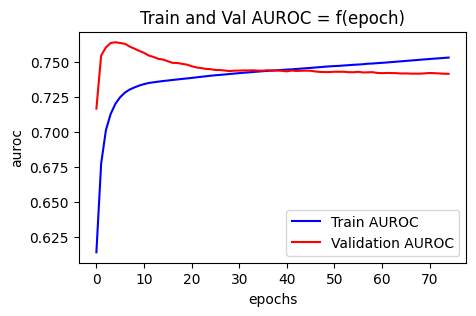

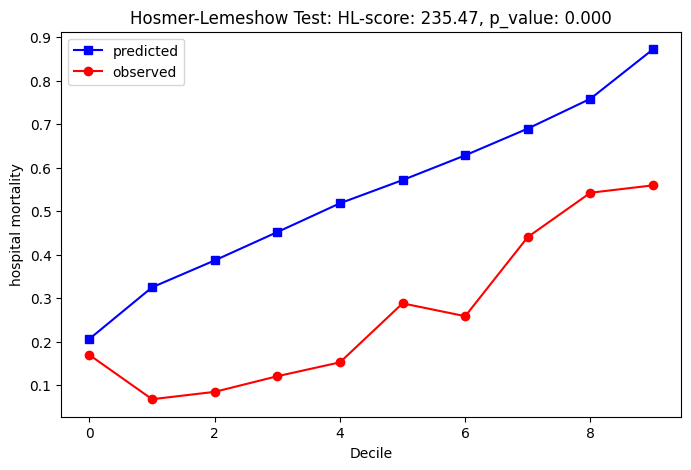

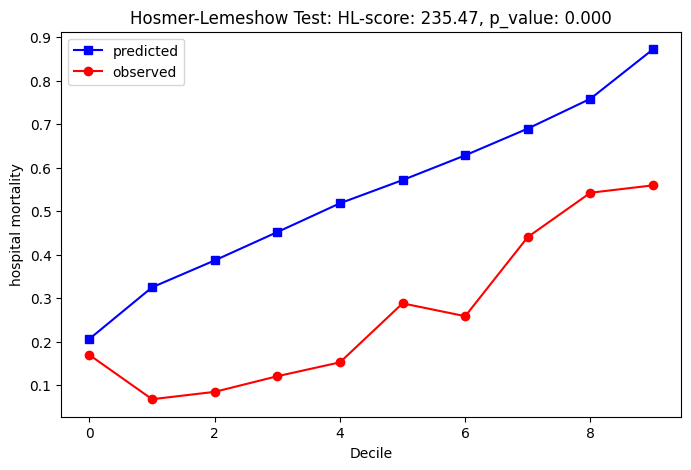


 10%|███████████████▉                                                                                                                                               | 1/10 [00:23<03:31, 23.45s/it]

test AUROC: 0.735
test Precision: 0.381
test Recall: 0.823
test Specificity: 0.420
test Accuracy: 0.594
test F1 Score: 0.521
test HL Score: 235.47
(4705, 120, 12)
(4705,)
tensor([1.3540, 3.8252])
Epoch 1/75, Train loss: 85.658, Train AUROC: 0.618
Validation Loss: 11.584, Validation AUROC: 0.646
Epoch 2/75, Train loss: 82.430, Train AUROC: 0.675
Validation Loss: 11.273, Validation AUROC: 0.679
Epoch 3/75, Train loss: 80.160, Train AUROC: 0.705
Validation Loss: 11.059, Validation AUROC: 0.700
Epoch 4/75, Train loss: 79.036, Train AUROC: 0.716
Validation Loss: 10.982, Validation AUROC: 0.708
Epoch 5/75, Train loss: 78.452, Train AUROC: 0.722
Validation Loss: 10.951, Validation AUROC: 0.712
Epoch 6/75, Train loss: 78.049, Train AUROC: 0.725
Validation Loss: 10.936, Validation AUROC: 0.714
Epoch 7/75, Train loss: 77.747, Train AUROC: 0.728
Validation Loss: 10.928, Validation AUROC: 0.715
Epoch 8/75, Train loss: 77.501, Train AUROC: 0.730
Validation Loss: 10.921, Validation AUROC: 0.717
Epoc

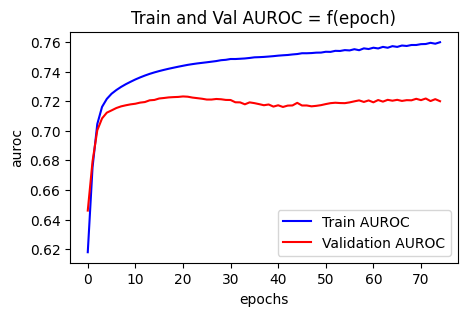

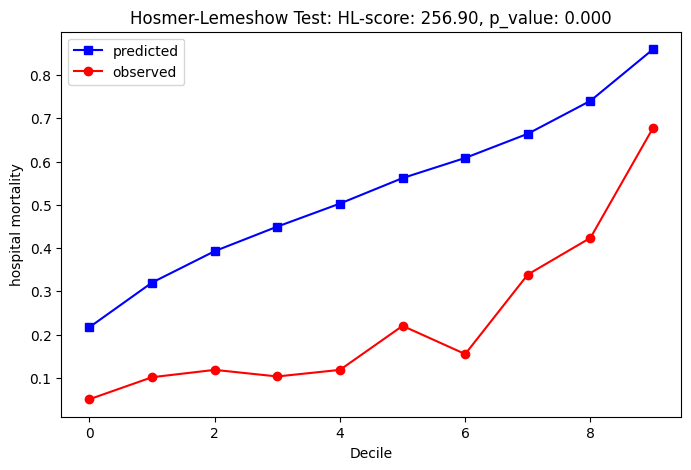

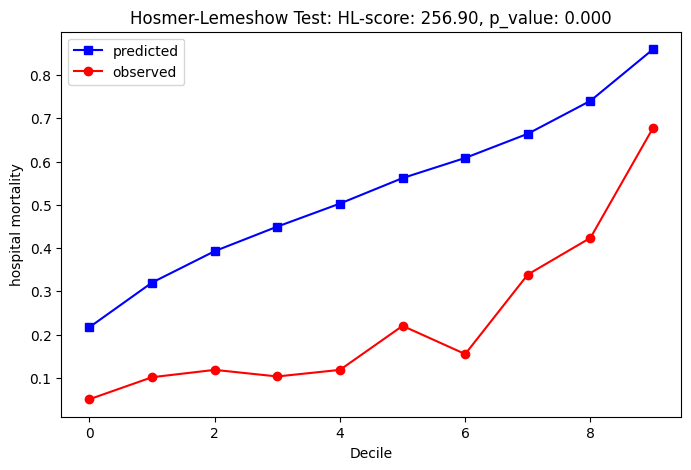


 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:46<03:04, 23.06s/it]

test AUROC: 0.763
test Precision: 0.337
test Recall: 0.809
test Specificity: 0.446
test Accuracy: 0.588
test F1 Score: 0.476
test HL Score: 256.90
(4705, 120, 12)
(4705,)
tensor([1.3505, 3.8534])
Epoch 1/75, Train loss: 87.056, Train AUROC: 0.616
Validation Loss: 11.040, Validation AUROC: 0.698
Epoch 2/75, Train loss: 83.848, Train AUROC: 0.655
Validation Loss: 10.690, Validation AUROC: 0.718
Epoch 3/75, Train loss: 81.966, Train AUROC: 0.677
Validation Loss: 10.466, Validation AUROC: 0.729
Epoch 4/75, Train loss: 81.020, Train AUROC: 0.689
Validation Loss: 10.319, Validation AUROC: 0.736
Epoch 5/75, Train loss: 80.476, Train AUROC: 0.695
Validation Loss: 10.219, Validation AUROC: 0.741
Epoch 6/75, Train loss: 80.128, Train AUROC: 0.699
Validation Loss: 10.148, Validation AUROC: 0.745
Epoch 7/75, Train loss: 79.880, Train AUROC: 0.702
Validation Loss: 10.097, Validation AUROC: 0.748
Epoch 8/75, Train loss: 79.669, Train AUROC: 0.704
Validation Loss: 10.055, Validation AUROC: 0.751
Epoc

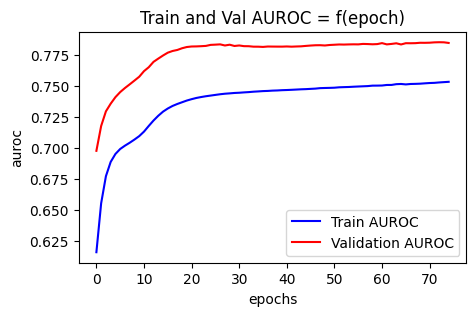

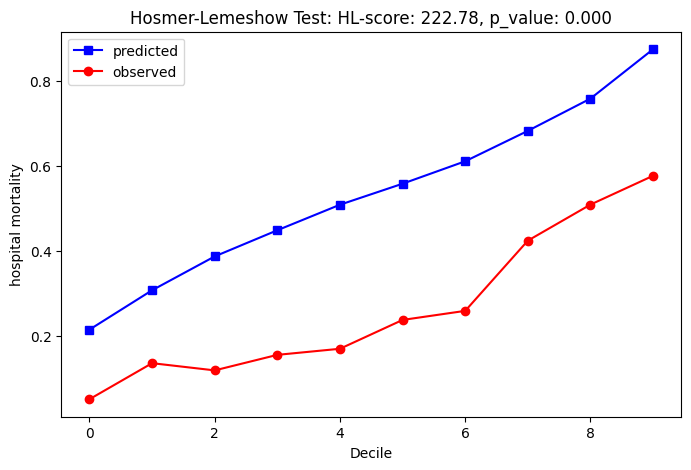

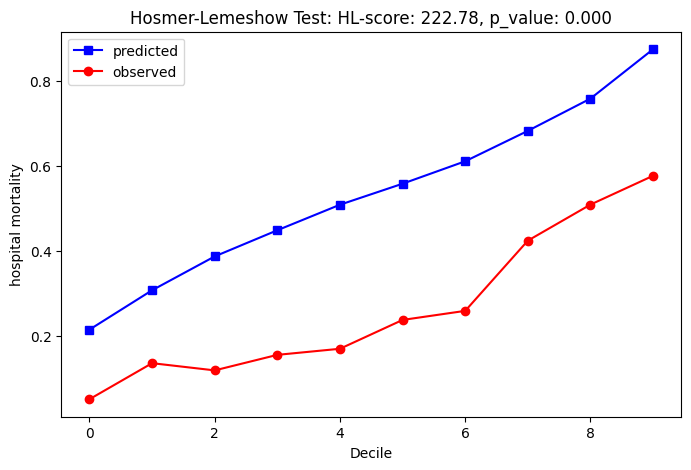


 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [01:08<02:39, 22.82s/it]

test AUROC: 0.742
test Precision: 0.378
test Recall: 0.806
test Specificity: 0.437
test Accuracy: 0.599
test F1 Score: 0.514
test HL Score: 222.78
(4704, 120, 12)
(4704,)
tensor([1.3525, 3.8369])
Epoch 1/75, Train loss: 86.923, Train AUROC: 0.605
Validation Loss: 10.810, Validation AUROC: 0.660
Epoch 2/75, Train loss: 82.713, Train AUROC: 0.671
Validation Loss: 10.611, Validation AUROC: 0.683
Epoch 3/75, Train loss: 80.988, Train AUROC: 0.695
Validation Loss: 10.427, Validation AUROC: 0.694
Epoch 4/75, Train loss: 79.781, Train AUROC: 0.709
Validation Loss: 10.308, Validation AUROC: 0.700
Epoch 5/75, Train loss: 78.903, Train AUROC: 0.717
Validation Loss: 10.233, Validation AUROC: 0.705
Epoch 6/75, Train loss: 78.353, Train AUROC: 0.723
Validation Loss: 10.179, Validation AUROC: 0.709
Epoch 7/75, Train loss: 77.968, Train AUROC: 0.727
Validation Loss: 10.138, Validation AUROC: 0.713
Epoch 8/75, Train loss: 77.674, Train AUROC: 0.730
Validation Loss: 10.105, Validation AUROC: 0.716
Epoc

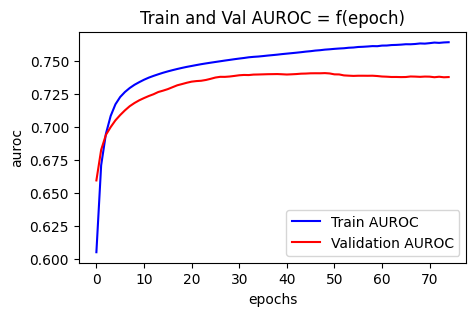

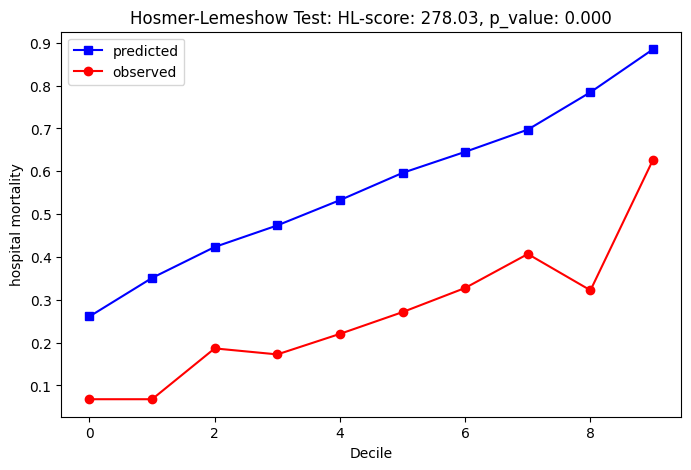

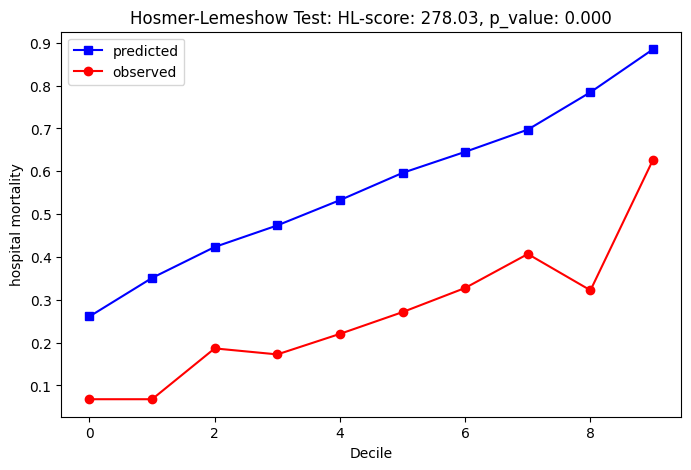


 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [01:31<02:17, 22.96s/it]

test AUROC: 0.714
test Precision: 0.365
test Recall: 0.815
test Specificity: 0.403
test Accuracy: 0.571
test F1 Score: 0.504
test HL Score: 278.03
(4705, 120, 12)
(4705,)
tensor([1.3435, 3.9111])
Epoch 1/75, Train loss: 85.220, Train AUROC: 0.632
Validation Loss: 11.293, Validation AUROC: 0.685
Epoch 2/75, Train loss: 82.138, Train AUROC: 0.679
Validation Loss: 11.042, Validation AUROC: 0.714
Epoch 3/75, Train loss: 80.628, Train AUROC: 0.702
Validation Loss: 10.881, Validation AUROC: 0.734
Epoch 4/75, Train loss: 79.591, Train AUROC: 0.715
Validation Loss: 10.796, Validation AUROC: 0.741
Epoch 5/75, Train loss: 79.072, Train AUROC: 0.720
Validation Loss: 10.756, Validation AUROC: 0.743
Epoch 6/75, Train loss: 78.726, Train AUROC: 0.723
Validation Loss: 10.726, Validation AUROC: 0.744
Epoch 7/75, Train loss: 78.448, Train AUROC: 0.725
Validation Loss: 10.705, Validation AUROC: 0.744
Epoch 8/75, Train loss: 78.215, Train AUROC: 0.727
Validation Loss: 10.689, Validation AUROC: 0.744
Epoc

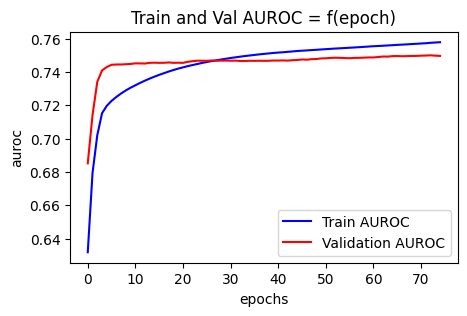

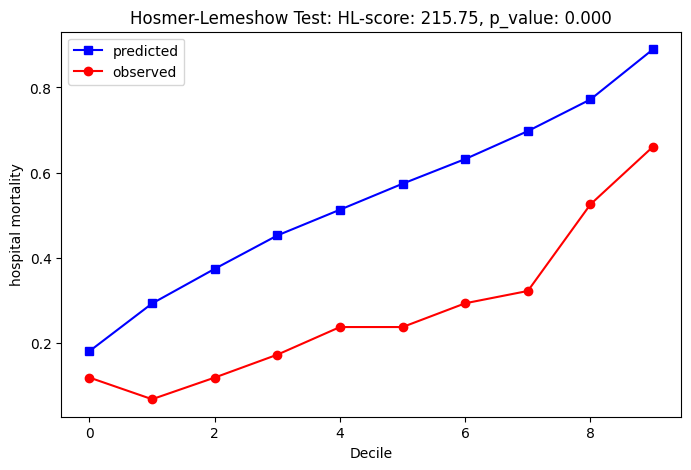

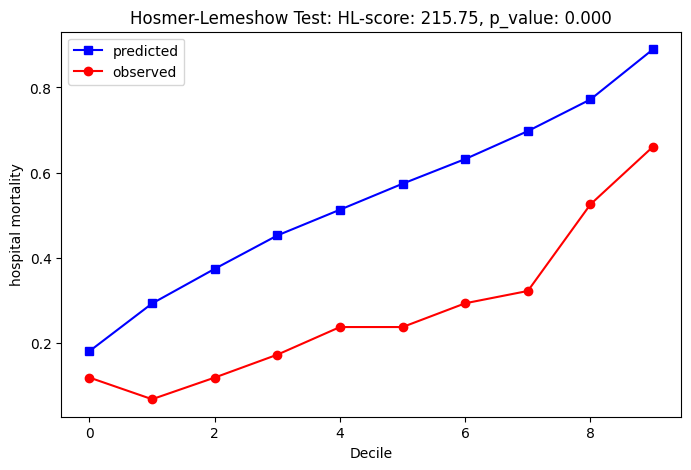


 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [01:54<01:54, 22.86s/it]

test AUROC: 0.742
test Precision: 0.393
test Recall: 0.815
test Specificity: 0.429
test Accuracy: 0.602
test F1 Score: 0.530
test HL Score: 215.75
(4705, 120, 12)
(4705,)
tensor([1.3481, 3.8724])
Epoch 1/75, Train loss: 90.694, Train AUROC: 0.587
Validation Loss: 12.751, Validation AUROC: 0.629
Epoch 2/75, Train loss: 87.220, Train AUROC: 0.622
Validation Loss: 12.373, Validation AUROC: 0.635
Epoch 3/75, Train loss: 85.296, Train AUROC: 0.641
Validation Loss: 12.105, Validation AUROC: 0.650
Epoch 4/75, Train loss: 83.757, Train AUROC: 0.661
Validation Loss: 11.871, Validation AUROC: 0.666
Epoch 5/75, Train loss: 82.479, Train AUROC: 0.678
Validation Loss: 11.677, Validation AUROC: 0.679
Epoch 6/75, Train loss: 81.426, Train AUROC: 0.691
Validation Loss: 11.541, Validation AUROC: 0.688
Epoch 7/75, Train loss: 80.621, Train AUROC: 0.699
Validation Loss: 11.460, Validation AUROC: 0.694
Epoch 8/75, Train loss: 79.979, Train AUROC: 0.706
Validation Loss: 11.400, Validation AUROC: 0.697
Epoc

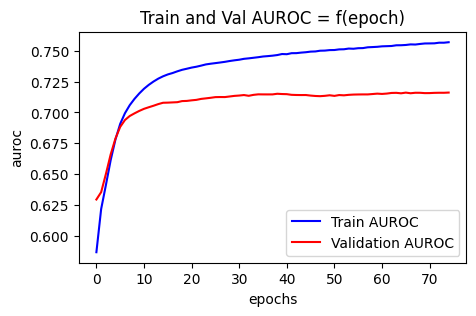

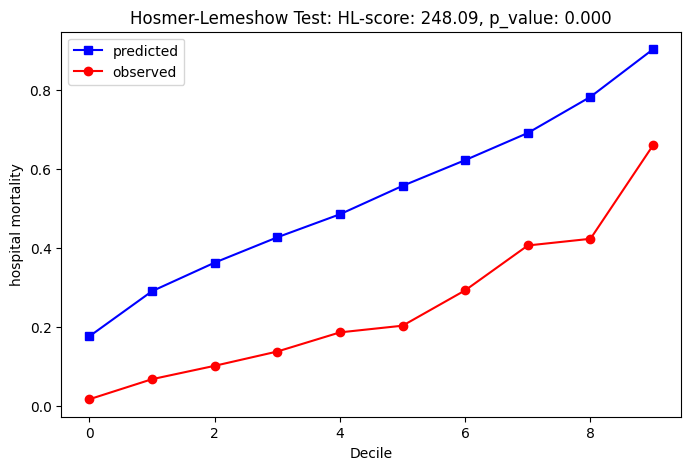

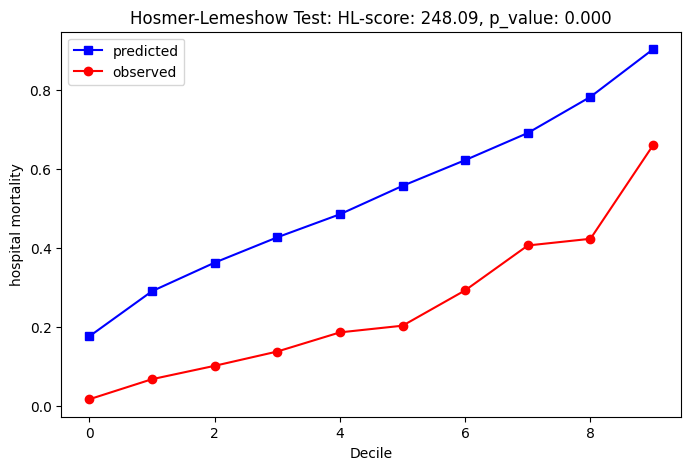


 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [02:17<01:31, 22.94s/it]

test AUROC: 0.780
test Precision: 0.388
test Recall: 0.816
test Specificity: 0.474
test Accuracy: 0.633
test F1 Score: 0.526
test HL Score: 248.09
(4704, 120, 12)
(4704,)
tensor([1.3568, 3.8027])
Epoch 1/75, Train loss: 85.325, Train AUROC: 0.617
Validation Loss: 10.978, Validation AUROC: 0.641
Epoch 2/75, Train loss: 82.910, Train AUROC: 0.663
Validation Loss: 10.796, Validation AUROC: 0.660
Epoch 3/75, Train loss: 81.483, Train AUROC: 0.684
Validation Loss: 10.653, Validation AUROC: 0.672
Epoch 4/75, Train loss: 80.440, Train AUROC: 0.697
Validation Loss: 10.525, Validation AUROC: 0.684
Epoch 5/75, Train loss: 79.615, Train AUROC: 0.707
Validation Loss: 10.406, Validation AUROC: 0.693
Epoch 6/75, Train loss: 78.972, Train AUROC: 0.714
Validation Loss: 10.320, Validation AUROC: 0.709
Epoch 7/75, Train loss: 78.337, Train AUROC: 0.720
Validation Loss: 10.212, Validation AUROC: 0.715
Epoch 8/75, Train loss: 77.761, Train AUROC: 0.726
Validation Loss: 10.151, Validation AUROC: 0.722
Epoc

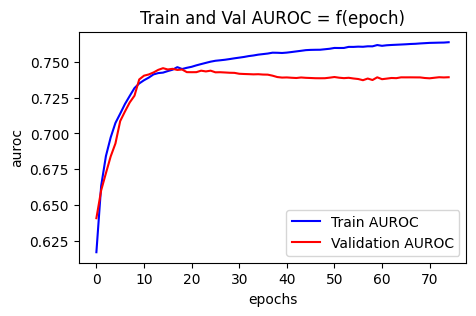

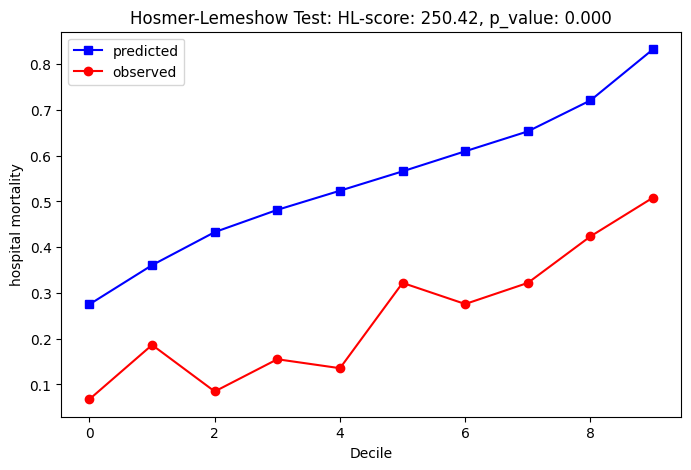

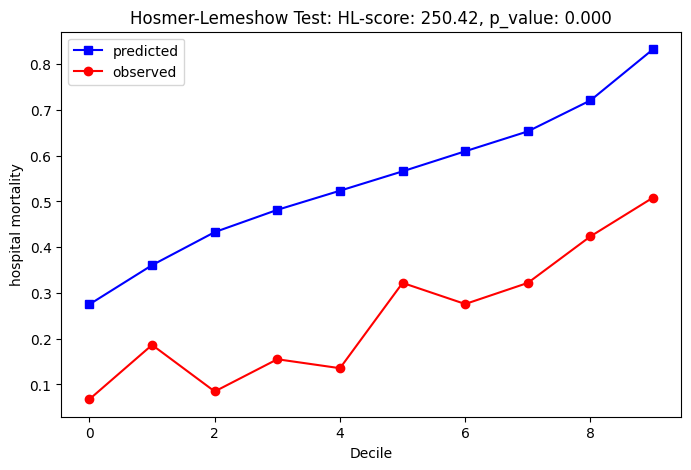


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [02:40<01:08, 22.99s/it]

test AUROC: 0.702
test Precision: 0.331
test Recall: 0.801
test Specificity: 0.398
test Accuracy: 0.548
test F1 Score: 0.468
test HL Score: 250.42
(4705, 120, 12)
(4705,)
tensor([1.3524, 3.8377])
Epoch 1/75, Train loss: 87.133, Train AUROC: 0.579
Validation Loss: 11.031, Validation AUROC: 0.642
Epoch 2/75, Train loss: 84.032, Train AUROC: 0.644
Validation Loss: 10.574, Validation AUROC: 0.699
Epoch 3/75, Train loss: 81.484, Train AUROC: 0.685
Validation Loss: 10.256, Validation AUROC: 0.733
Epoch 4/75, Train loss: 79.717, Train AUROC: 0.706
Validation Loss: 10.130, Validation AUROC: 0.746
Epoch 5/75, Train loss: 78.763, Train AUROC: 0.717
Validation Loss: 10.053, Validation AUROC: 0.750
Epoch 6/75, Train loss: 78.216, Train AUROC: 0.722
Validation Loss: 10.006, Validation AUROC: 0.751
Epoch 7/75, Train loss: 77.870, Train AUROC: 0.726
Validation Loss: 9.969, Validation AUROC: 0.752
Epoch 8/75, Train loss: 77.618, Train AUROC: 0.728
Validation Loss: 9.936, Validation AUROC: 0.752
Epoch 

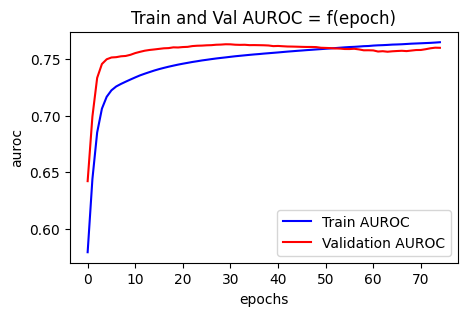

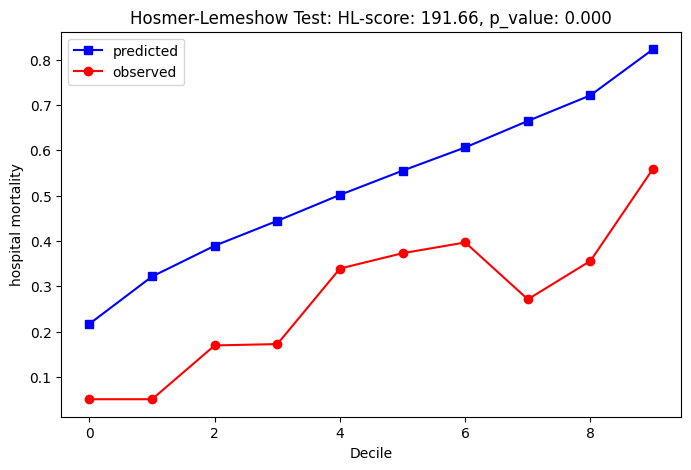

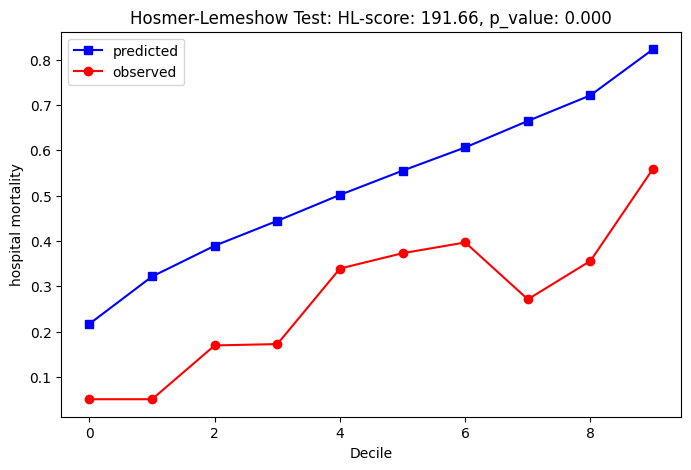


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [03:03<00:45, 22.90s/it]

test AUROC: 0.701
test Precision: 0.393
test Recall: 0.789
test Specificity: 0.451
test Accuracy: 0.609
test F1 Score: 0.525
test HL Score: 191.66
(4705, 120, 12)
(4705,)
tensor([1.3481, 3.8724])
Epoch 1/75, Train loss: 84.955, Train AUROC: 0.638
Validation Loss: 10.649, Validation AUROC: 0.709
Epoch 2/75, Train loss: 82.317, Train AUROC: 0.678
Validation Loss: 10.320, Validation AUROC: 0.737
Epoch 3/75, Train loss: 81.034, Train AUROC: 0.695
Validation Loss: 10.173, Validation AUROC: 0.758
Epoch 4/75, Train loss: 80.079, Train AUROC: 0.707
Validation Loss: 9.969, Validation AUROC: 0.770
Epoch 5/75, Train loss: 79.314, Train AUROC: 0.715
Validation Loss: 9.877, Validation AUROC: 0.777
Epoch 6/75, Train loss: 78.778, Train AUROC: 0.720
Validation Loss: 9.838, Validation AUROC: 0.783
Epoch 7/75, Train loss: 78.387, Train AUROC: 0.724
Validation Loss: 9.817, Validation AUROC: 0.786
Epoch 8/75, Train loss: 78.074, Train AUROC: 0.727
Validation Loss: 9.801, Validation AUROC: 0.788
Epoch 9/7

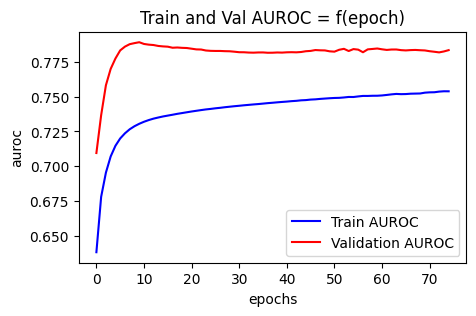

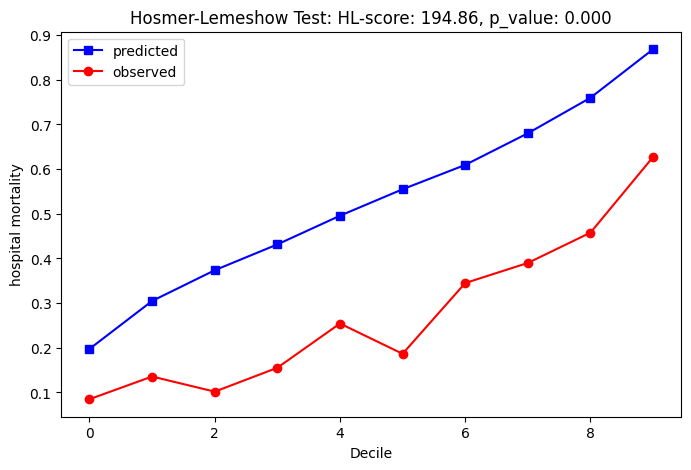

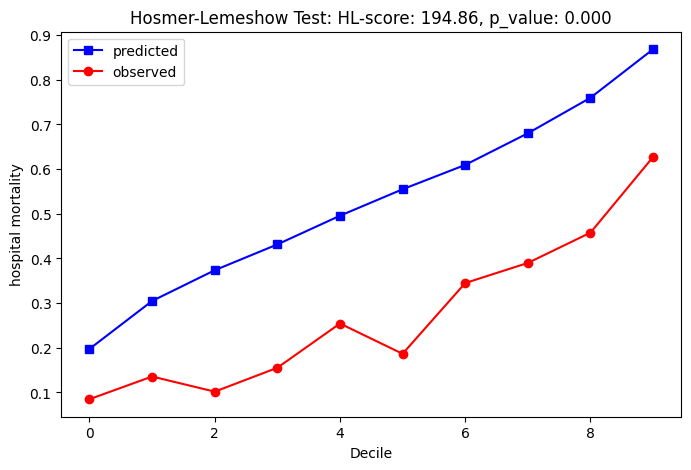


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [03:26<00:22, 22.80s/it]

test AUROC: 0.733
test Precision: 0.401
test Recall: 0.789
test Specificity: 0.461
test Accuracy: 0.619
test F1 Score: 0.531
test HL Score: 194.86
(4704, 120, 12)
(4704,)
tensor([1.3607, 3.7723])
Epoch 1/75, Train loss: 86.834, Train AUROC: 0.578
Validation Loss: 10.991, Validation AUROC: 0.682
Epoch 2/75, Train loss: 83.285, Train AUROC: 0.661
Validation Loss: 10.536, Validation AUROC: 0.713
Epoch 3/75, Train loss: 81.621, Train AUROC: 0.684
Validation Loss: 10.328, Validation AUROC: 0.720
Epoch 4/75, Train loss: 80.616, Train AUROC: 0.696
Validation Loss: 10.240, Validation AUROC: 0.723
Epoch 5/75, Train loss: 79.937, Train AUROC: 0.703
Validation Loss: 10.198, Validation AUROC: 0.726
Epoch 6/75, Train loss: 79.454, Train AUROC: 0.708
Validation Loss: 10.162, Validation AUROC: 0.728
Epoch 7/75, Train loss: 79.068, Train AUROC: 0.713
Validation Loss: 10.129, Validation AUROC: 0.731
Epoch 8/75, Train loss: 78.740, Train AUROC: 0.716
Validation Loss: 10.097, Validation AUROC: 0.733
Epoc

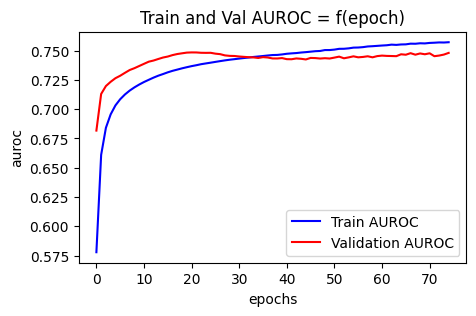

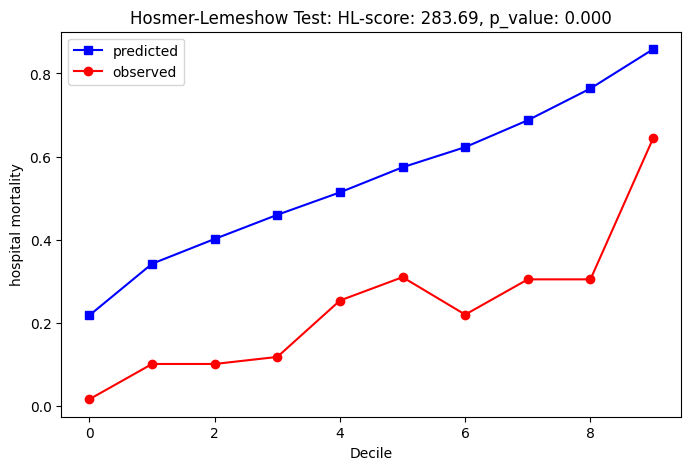

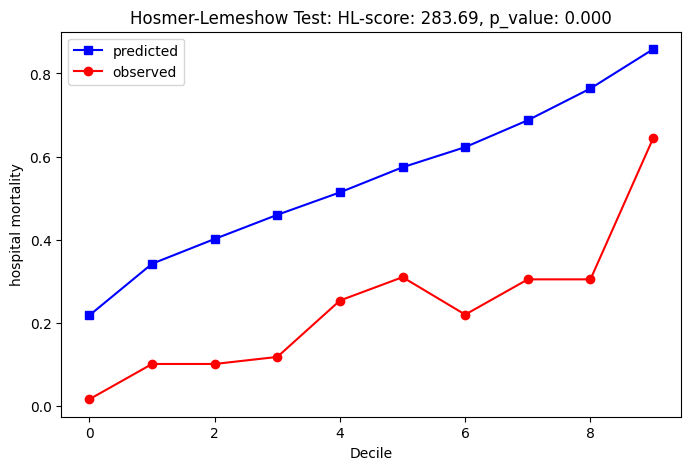


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:49<00:00, 229.30s/it]

test AUROC: 0.735
test Precision: 0.345
test Recall: 0.829
test Specificity: 0.430
test Accuracy: 0.586
test F1 Score: 0.487
test HL Score: 283.69
Mean AUROC: 0.735
Mean Precision: 0.371
Mean Recall: 0.809
Mean Specificity: 0.435
Mean Accuracy: 0.595
Mean F1 Score: 0.508
SD Auroc: 0.023
Mean HL Score: 237.77
Total Mean AUROC: 0.735
Total Mean Precision: 0.371
Total Mean Recall: 0.809
Total Mean Specificity: 0.435
Total Mean Accuracy: 0.595
Total Mean F1 Score: 0.508
Total Mean HL Score: 237.77


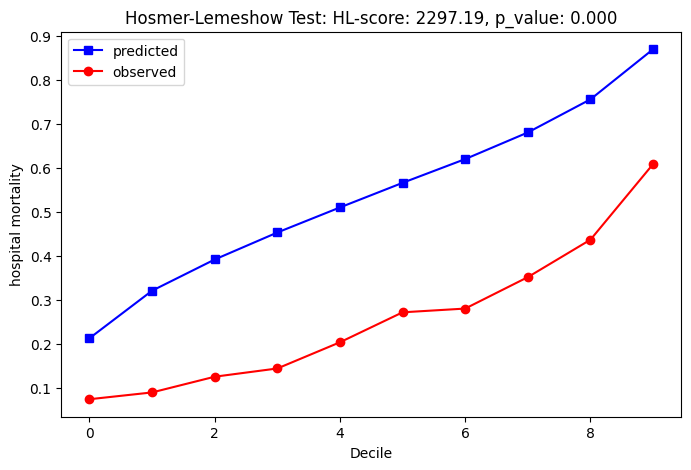

In [15]:
best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_mean = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []  
HLs_mean = []

mean_fpr = np.linspace(0, 1, 100)
tprs = []
predictions_list = []
labels_list = []

save_path = "saved_models/test1.pth"
load_path = "saved_models/cnn_1d_76_76.pth"

K = 10
num_train = 1

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []    
    HLs = []
    
    for j in tqdm(range(10)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, state_dict, mean_true, predictions, true_labels  =  train_model(
                                                                                    data=data_MR,
                                                                                    target=target_MR,
                                                                                    test_fold = j,
                                                                                    validation_activated=True,
                                                                                    test_activated = True,
                                                                                    num_epochs=75, 
                                                                                    model_name="InceptionTime",
                                                                                    verbose=True, 
                                                                                    save_path=save_path, 
                                                                                    save_model=True, 
                                                                                    plot_train_curves = True,
                                                                                    load_model_path = None)
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        HLs.append(HL_score)
        
        print(f"test AUROC: {auroc:.3f}")
        print(f"test Precision: {precision:.3f}")
        print(f"test Recall: {recall:.3f}")
        print(f"test Specificity: {tnr:.3f}")
        print(f"test Accuracy: {accuracy:.3f}")
        print(f"test F1 Score: {f1:.3f}")
        print(f"test HL Score: {HL_score:.2f}")

        fpr, tpr, _ = roc_curve(true_labels, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        predictions_list = predictions_list + list(predictions)
        labels_list = labels_list + list(true_labels)
    
    print(f"Mean AUROC: {np.mean(aurocs):.3f}")
    print(f"Mean Precision: {np.mean(precisions):.3f}")
    print(f"Mean Recall: {np.mean(recalls):.3f}")
    print(f"Mean Specificity: {np.mean(tnrs):.3f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.3f}")
    print(f"Mean F1 Score: {np.mean(f1s):.3f}")
    print(f"SD Auroc: {np.std(aurocs):.3f}")
    print(f"Mean HL Score: {np.mean(HLs):.2f}")

    aurocs_mean.append(np.mean(aurocs))
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
    HLs_mean.append(np.mean(HLs))
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_mean):.3f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.3f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.3f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.3f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.3f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.3f}")
print(f"Total Mean HL Score: {np.mean(HLs_mean):.2f}")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)

list_to_save = [aurocs, mean_tpr, predictions_list, labels_list]

# saved_results_folder = "./saved_results/"
# saved_file_name = "InceptionTime_ECMO"

# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)

deciles = np.percentile(predictions_list, np.arange(0, 101, 10))
decile_labels = pd.cut(predictions_list, bins=deciles, labels=False, include_lowest=True)

HL_num_groups = np.zeros(10)
HL_pred_groups = np.zeros(10)
HL_true_groups = np.zeros(10)

for k in range(len(predictions_list)):
    group = decile_labels[k]
    HL_num_groups[group] +=1
    HL_pred_groups[group] += predictions_list[k]
    if labels_list[k] > 0.5:
        HL_true_groups[group] += 1
        
HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
HL_p_value = 1 - chi2.cdf(HL_score, df=8)

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

plt.xlabel('Decile')
plt.ylabel('hospital mortality')
plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

plt.legend()

plt.show()

In [16]:
num_features = np.size(data_ECMO,2)
num_features_dynamic = 9
num_features_static = 3


model = InceptionModel(num_blocks=1, in_channels=12, out_channels=32,
                           bottleneck_channels=1, kernel_sizes=41, 
                           use_residuals=True, num_pred_classes=1)

save_path = "./saved_models/test.pth"
model_state_dict = torch.load(save_path)
model.load_state_dict(model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels = []
predictions = []
predictions_binary = []

treshold = 0.5

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        true_labels.extend(labels.numpy())

        outputs = nn.functional.sigmoid(model(inputs))

            
        predictions.extend(outputs.numpy())
        predictions_binary.extend((outputs.numpy() > treshold).astype(int))


mean_fpr = np.linspace(0, 1, 100)
tprs = []
predictions_list = []
labels_list = []

fpr, tpr, _ = roc_curve(true_labels, predictions)
tprs.append(np.interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0

predictions_list = predictions_list + list(predictions)
labels_list = labels_list + list(true_labels)

auroc = roc_auc_score(true_labels, predictions)
print(auroc)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)

list_to_save = [auroc, mean_tpr, predictions_list, labels_list]

saved_file_name = "InceptionTime_Mimic_On_ECMO"

# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)

RuntimeError: Error(s) in loading state_dict for InceptionModel:
	Missing key(s) in state_dict: "blocks.0.bottleneck.weight", "blocks.0.conv_layers.0.weight", "blocks.0.conv_layers.1.weight", "blocks.0.conv_layers.2.weight", "blocks.0.batchnorm.weight", "blocks.0.batchnorm.bias", "blocks.0.batchnorm.running_mean", "blocks.0.batchnorm.running_var", "blocks.0.residual.0.weight", "blocks.0.residual.1.weight", "blocks.0.residual.1.bias", "blocks.0.residual.1.running_mean", "blocks.0.residual.1.running_var", "linear.weight", "linear.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

In [ ]:
num_features = np.size(data_ECMO,2)
num_features_dynamic = 9
num_features_static = 3

input_size = 1
hidden_size = 16
num_layers = 2
output_size = 1

# model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)
# model = CNN_1D_1(num_features)
model = InceptionModel(num_blocks=1, 
                           in_channels=12, 
                           out_channels=8,
                           bottleneck_channels=1, 
                           kernel_sizes=41, 
                           use_residuals=True, 
                           num_pred_classes=1)

save_path = "./saved_models/test1.pth"
model_state_dict = torch.load(save_path)
model.load_state_dict(model_state_dict)
model.eval()

# Convert data to PyTorch tensors
x_test_tensor = torch.tensor(data_ECMO, dtype=torch.float32)
y_test_tensor = torch.tensor(target_ECMO, dtype=torch.float32)

# Create DataLoader for training and testing sets
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels = []
predictions = []
predictions_binary = []

treshold = 0.5

HL_num_groups = np.zeros(10)
HL_pred_groups = np.zeros(10)
HL_true_groups = np.zeros(10)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        true_labels.extend(labels.numpy())

        outputs = nn.functional.sigmoid(model(inputs))
        
        # for k in range(len(outputs)):
        #             pred = outputs[k][0]
        #             group = min(9,int(pred * 10))
        #             outputs[k][0] = mean_true[group]
            
        predictions.extend(outputs.numpy())
        predictions_binary.extend((outputs.numpy() > treshold).astype(int))
        
        # print(np.round(np.array([p[0] for p in outputs.numpy()]), 1))
        # print(np.round(np.array(labels), 1))
        for k in range(len(outputs)):
            pred = outputs[k][0]
            group = int(pred * 10)
            group = min(group,9)
            HL_num_groups[group] +=1
            HL_pred_groups[group] += pred
            if labels[k] > 0.5:
                HL_true_groups[group] += 1
        
    # print(np.round(np.array([p[0] for p in predictions]), 1))

HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

plt.figure(figsize=(5, 3))

plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

plt.xlabel('predicted mortality')
plt.ylabel('hospital mortality')
plt.title('Hosmer-Lemeshow Test')

plt.legend()

plt.show()
auroc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
f1 = f1_score(true_labels, predictions_binary, zero_division=0)
accuracy = accuracy_score(true_labels, predictions_binary)

print(f"AUROC: {auroc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Specificity: {tnr:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"HL Score: {HL_score:.3f}")
print(np.round(predictions,2).squeeze())
print(np.array(true_labels).astype(int))

  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


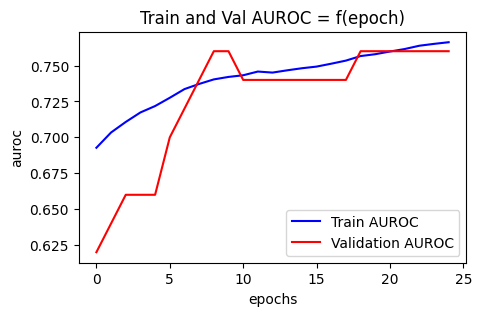

[       nan 0.         0.         0.                nan 0.
 0.4        0.23170732 0.46341463 0.51282051]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


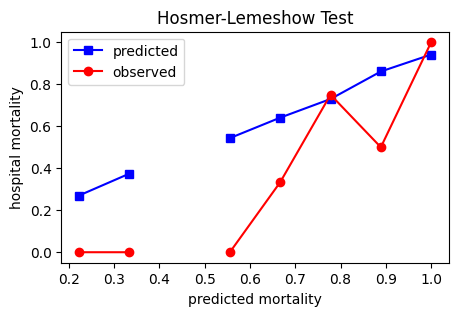

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:01<00:09,  1.04s/it]

test AUROC: 0.8519
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 7.4145
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


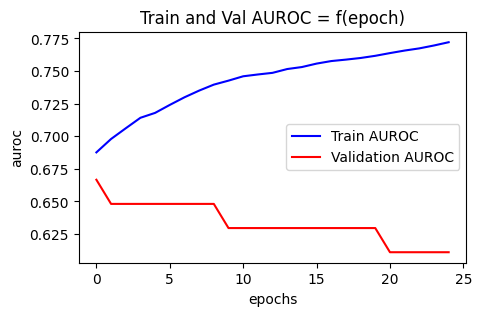

[       nan 0.         0.         0.07407407 0.61111111 0.61627907
 0.60526316 0.1147541  0.40350877 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


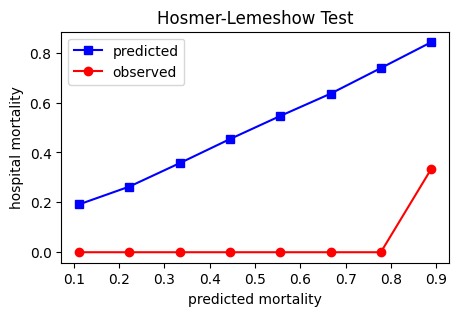

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.03s/it]

test AUROC: 1.0000
test Precision: 0.1250
test Recall: 1.0000
test Specificity: 0.4667
test Accuracy: 0.5333
test F1 Score: 0.2222
test HL Score: 17.9008
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


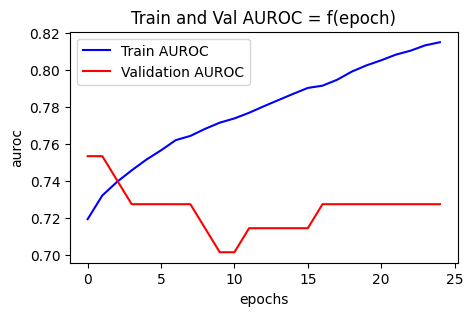

[       nan 0.         0.46296296 0.5        0.         0.36585366
 0.17647059 0.18367347 0.98       1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


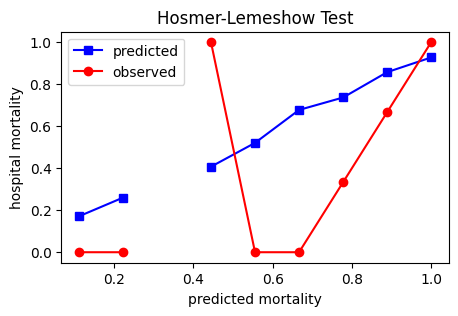

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.01s/it]

test AUROC: 0.7963
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 11.2200
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


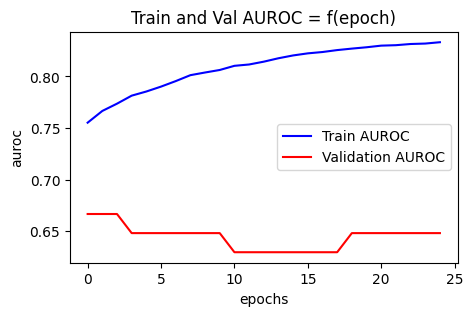

[0.         0.         0.         0.13793103 0.45652174 0.71428571
 0.65789474 0.         0.35211268 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


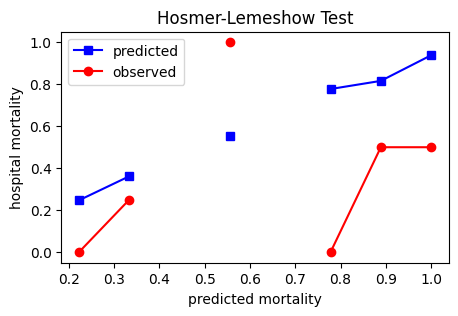

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.00s/it]

test AUROC: 0.6200
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 20.8890
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


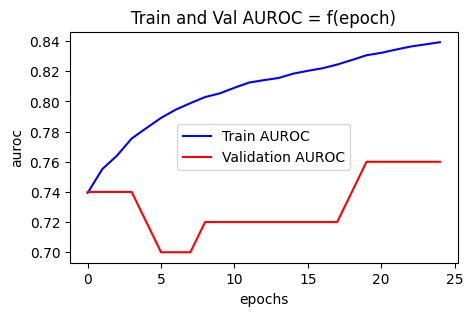

[       nan        nan        nan 0.         0.         0.
 0.3125     0.74324324 0.30864198 0.5       ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


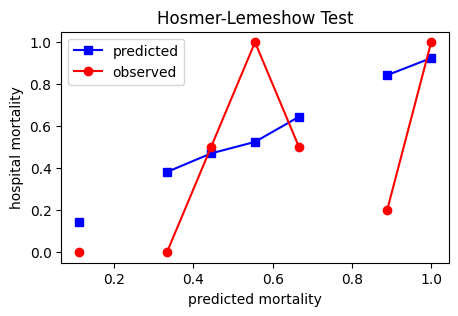

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.00s/it]

test AUROC: 0.6111
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 18.6580
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


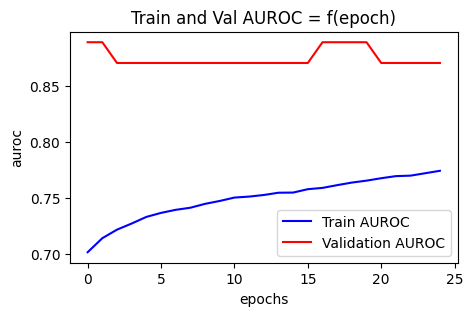

[       nan 0.         0.         0.         0.         0.09375
 0.265625   0.62222222 0.6        0.75925926]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


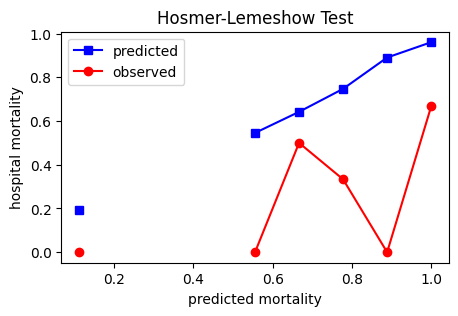

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:03,  1.00it/s]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 28.7770
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


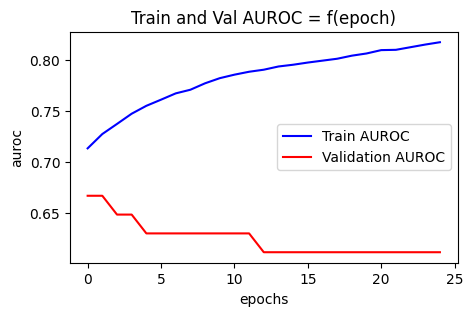

[       nan 0.         0.         0.13793103 0.45652174 0.67948718
 0.64705882 0.10869565 0.32857143 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


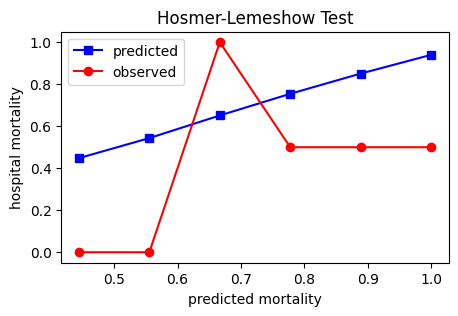

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:02,  1.01it/s]

test AUROC: 0.7400
test Precision: 0.4167
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 17.9703
(164, 120, 12)
(164,)
tensor([2., 2.])


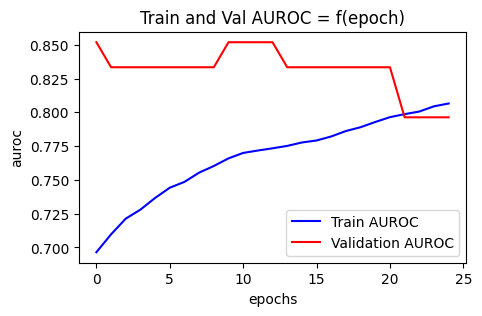

[       nan 0.         0.         0.         0.         0.14285714
 0.47761194 0.6119403  0.62       0.75510204]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


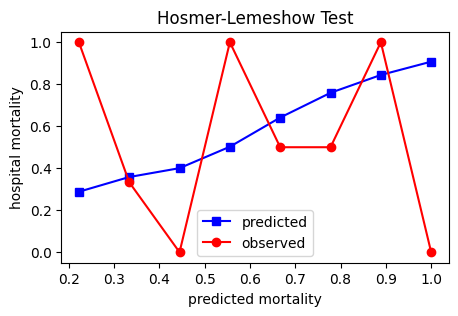

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:07<00:01,  1.01it/s]

test AUROC: 0.5536
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 15.9529
(164, 120, 12)
(164,)
tensor([2., 2.])


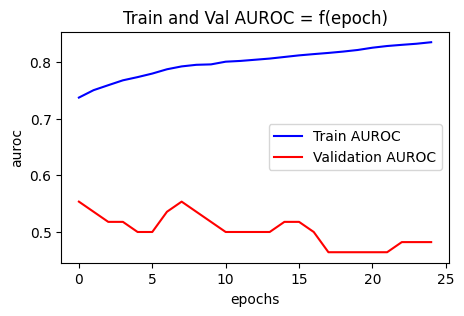

[       nan        nan 1.         0.81578947 0.         1.
 0.84090909 0.41666667 0.62727273 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups


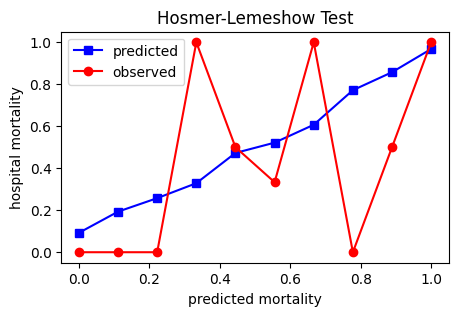


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:08<00:00,  1.02it/s]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 12.6841
(163, 120, 12)
(163,)
tensor([2.1169, 1.8953])


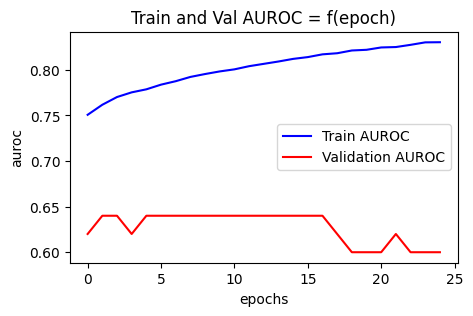

[       nan        nan 0.         0.17647059 0.11904762 0.44444444
 0.68115942 0.         0.23809524 0.48076923]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


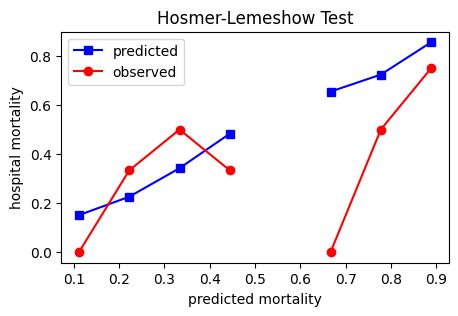

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:09<01:29,  9.95s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 5.6988
Mean AUROC: 0.7194
Mean Precision: 0.4342
Mean Recall: 0.8455
Mean Specificity: 0.3222
Mean Accuracy: 0.5544
Mean F1 Score: 0.5521
SD Auroc: 0.1295



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(164, 120, 12)
(164,)
tensor([2., 2.])


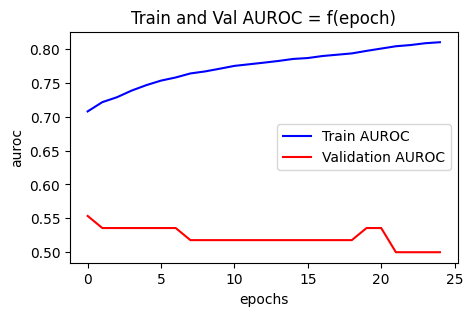

[       nan        nan 1.         0.86       0.10344828 0.33333333
 0.85       0.40277778 0.6124031  0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


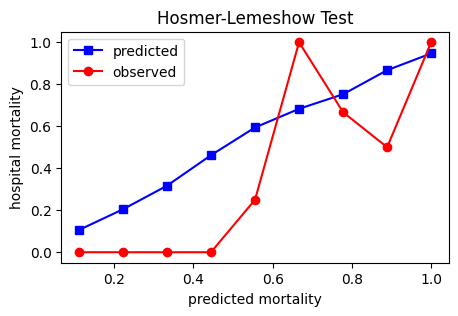

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.03it/s]

test AUROC: 0.8519
test Precision: 0.5455
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.6667
test F1 Score: 0.7059
test HL Score: 6.6304
(167, 120, 12)
(167,)
tensor([2.2877, 1.7766])


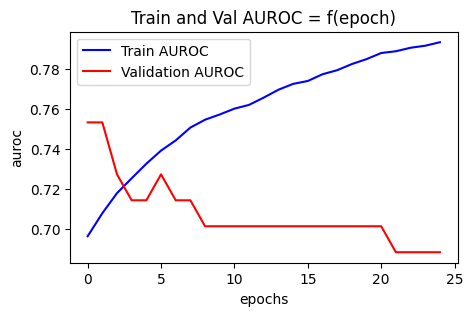

[       nan 0.         0.3164557  0.67567568 0.16216216 0.32653061
 0.06818182 0.24271845 0.98275862 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


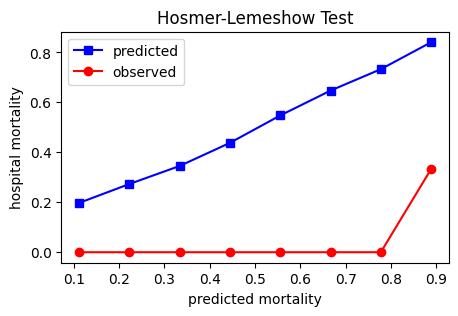

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:01<00:07,  1.00it/s]

test AUROC: 1.0000
test Precision: 0.1250
test Recall: 1.0000
test Specificity: 0.4667
test Accuracy: 0.5333
test F1 Score: 0.2222
test HL Score: 17.9838
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


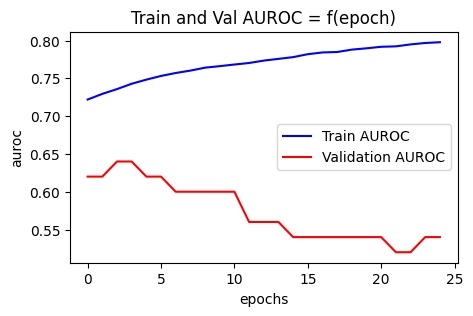

[       nan        nan 0.         0.14285714 0.46666667 0.56140351
 0.41860465 0.1        0.2183908  0.89285714]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


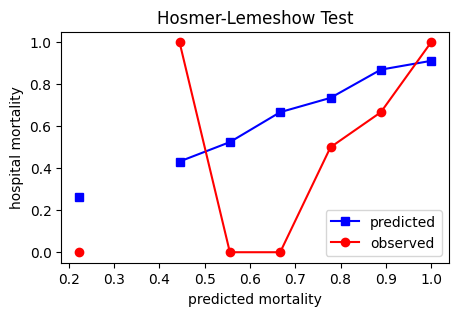

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:02<00:07,  1.00s/it]

test AUROC: 0.8333
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 9.8138
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


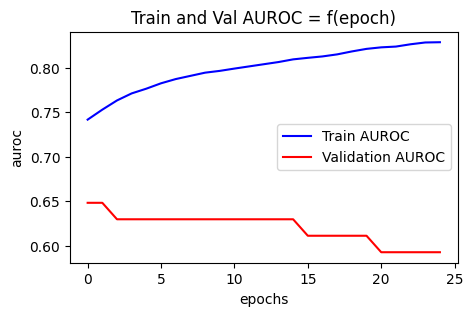

[0.         0.         0.         0.13793103 0.65277778 0.64864865
 0.53191489 0.09433962 0.32258065 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


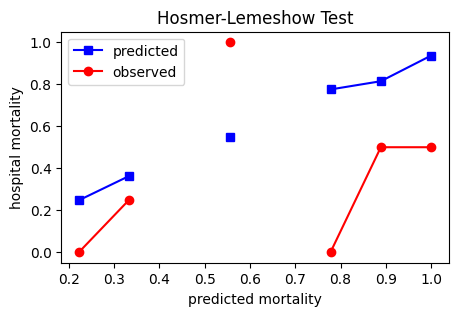

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:03<00:06,  1.00s/it]

test AUROC: 0.6200
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 20.5705
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


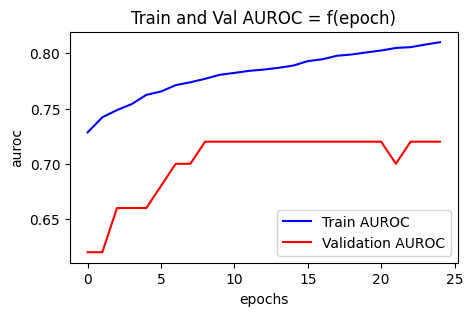

[       nan 0.         0.                nan 0.         0.
 0.42028986 0.13402062 0.66071429 0.51111111]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


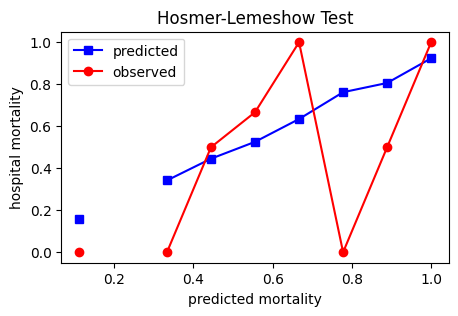

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:04<00:04,  1.00it/s]

test AUROC: 0.6481
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 12.6192
(172, 120, 12)
(172,)
tensor([2.3243, 1.7551])


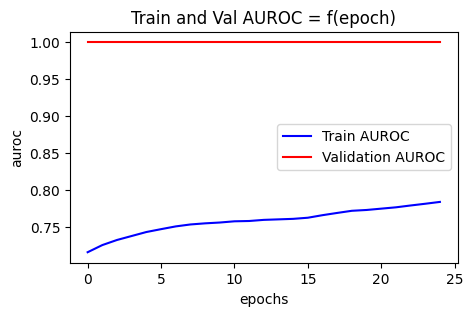

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.86206897        nan]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


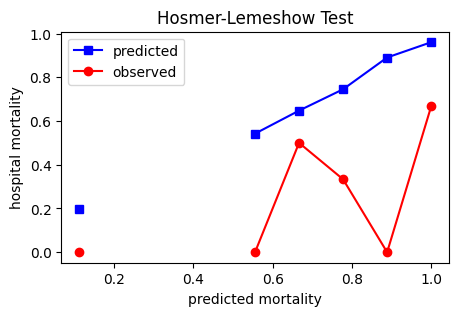

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.01s/it]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 28.6610
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


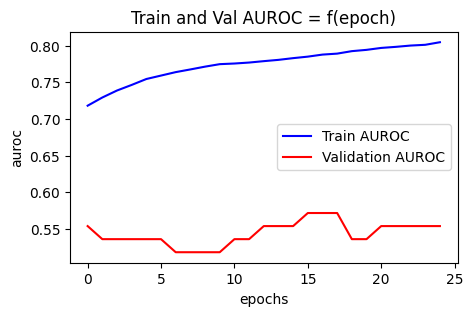

[       nan        nan 1.         0.72727273 0.30864198 0.52380952
 0.79545455 0.41333333 0.61344538 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


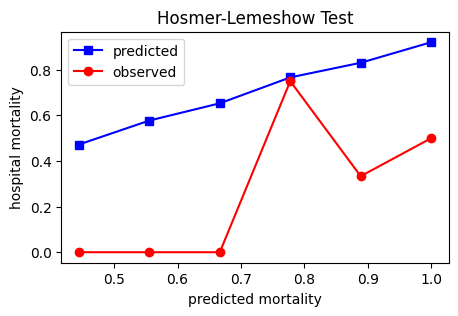

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:06<00:02,  1.01it/s]

test AUROC: 0.7400
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 18.8832
(160, 120, 12)
(160,)
tensor([2., 2.])


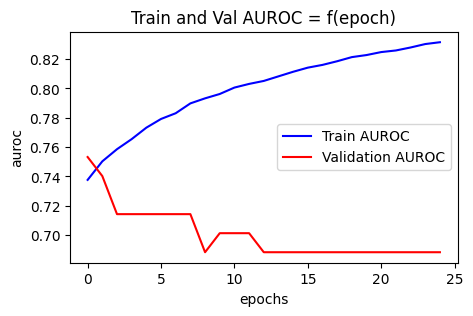

[       nan 0.18571429 0.43181818 0.40909091 0.48717949 0.18181818
 0.         0.28409091 0.8        1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


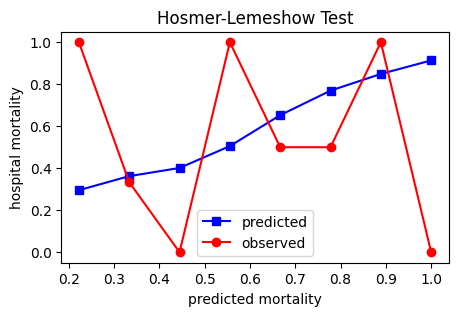

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:07<00:01,  1.01it/s]

test AUROC: 0.5536
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 16.7769
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


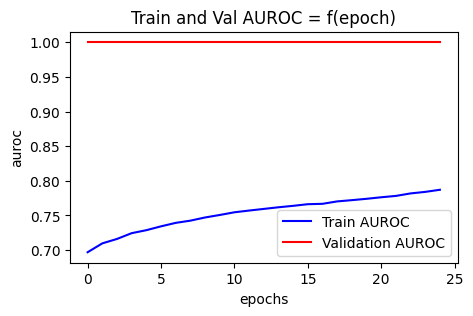

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.49019608        nan]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


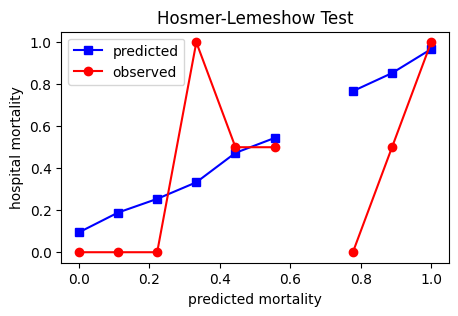

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:08<00:01,  1.00s/it]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 11.3256
(163, 120, 12)
(163,)
tensor([2.1169, 1.8953])


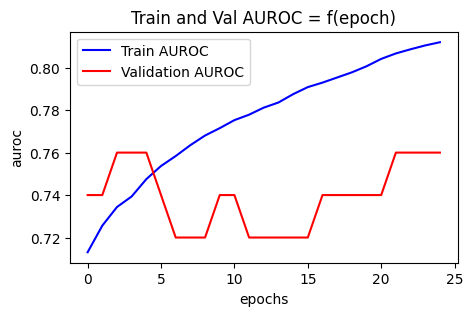

[       nan        nan        nan 0.         0.         0.
 0.15254237 0.78431373 0.43589744 0.5       ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


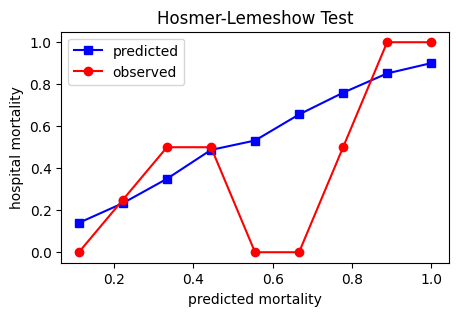

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:19<01:19,  9.96s/it]

test AUROC: 0.7143
test Precision: 0.4444
test Recall: 0.5714
test Specificity: 0.5000
test Accuracy: 0.5556
test F1 Score: 0.5000
test HL Score: 8.4244
Mean AUROC: 0.7229
Mean Precision: 0.4273
Mean Recall: 0.8455
Mean Specificity: 0.3100
Mean Accuracy: 0.5422
Mean F1 Score: 0.5465
SD Auroc: 0.1292



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(164, 120, 12)
(164,)
tensor([2., 2.])


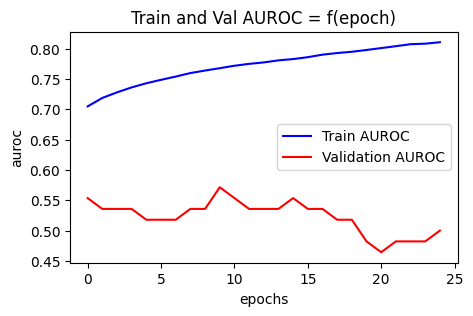

[       nan        nan 1.         0.82926829 0.23809524 0.33333333
 0.84375    0.48571429 0.60784314 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


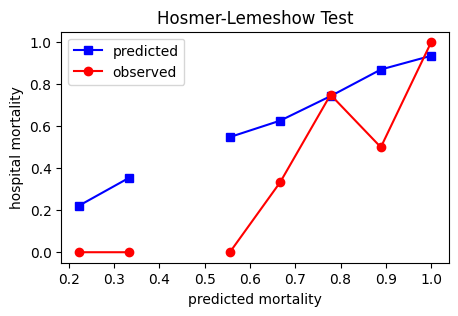

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.01it/s]

test AUROC: 0.8148
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 7.4053
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


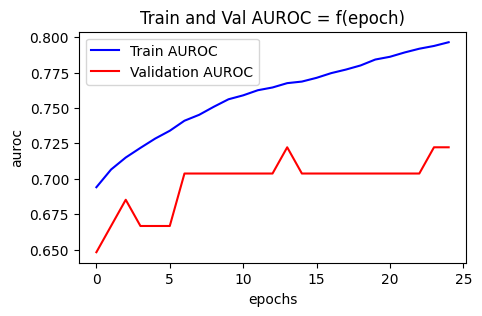

[0.         0.         0.         0.09090909 0.50847458 0.59259259
 1.         0.         0.56818182 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


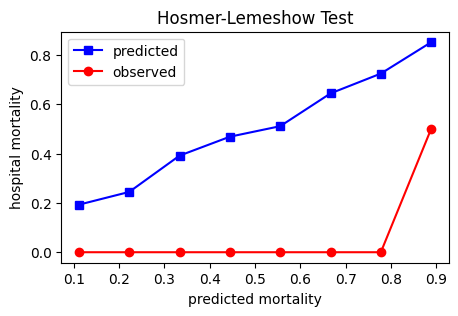

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.02s/it]

test AUROC: 1.0000
test Precision: 0.1111
test Recall: 1.0000
test Specificity: 0.4000
test Accuracy: 0.4667
test F1 Score: 0.2000
test HL Score: 19.2951
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


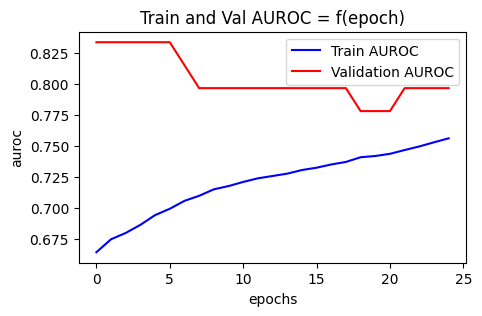

[       nan 0.         0.         0.         0.         0.1754386
 0.45283019 0.70422535 0.56578947 0.82142857]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


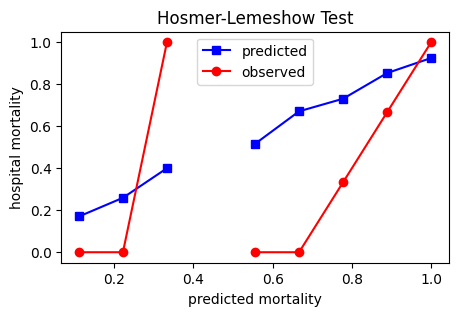

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.00s/it]

test AUROC: 0.7963
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 10.9563
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


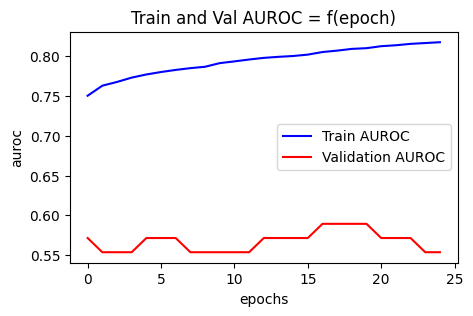

[       nan        nan 1.         0.44285714 0.33333333 1.
 0.8        0.34615385 0.67716535 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


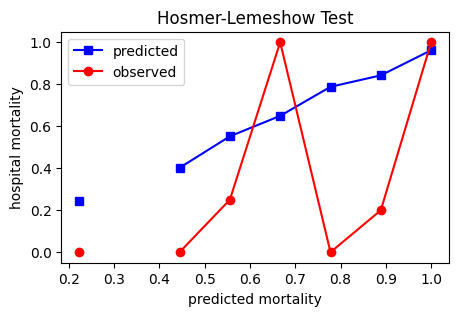

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.13s/it]

test AUROC: 0.6200
test Precision: 0.3846
test Recall: 1.0000
test Specificity: 0.1333
test Accuracy: 0.4667
test F1 Score: 0.5556
test HL Score: 22.8175
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


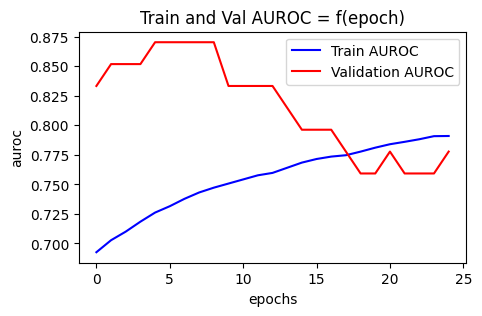

[       nan 0.         0.         0.         0.17391304 0.57142857
 0.14516129 0.23913043 0.76190476 0.66666667]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


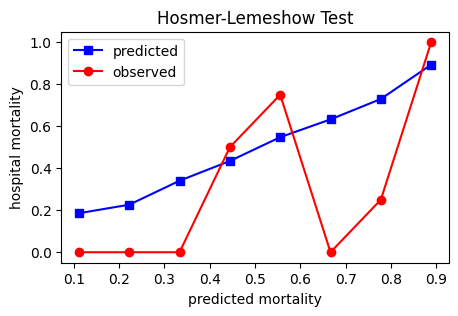

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.08s/it]

test AUROC: 0.6296
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 8.2408
(168, 120, 12)
(168,)
tensor([2.1538, 1.8667])


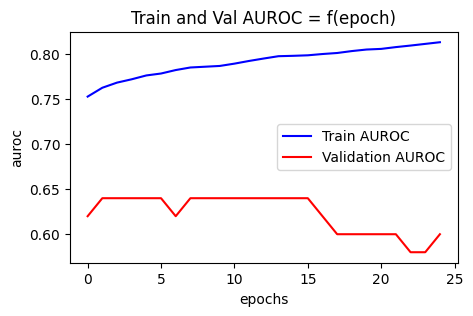

[       nan        nan 0.         0.15384615 0.275      0.61403509
 0.60526316 0.         0.2173913  0.53191489]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


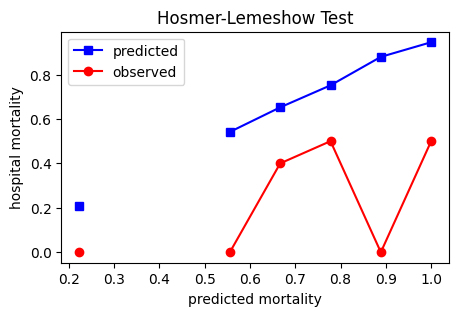

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.06s/it]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 27.3969
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


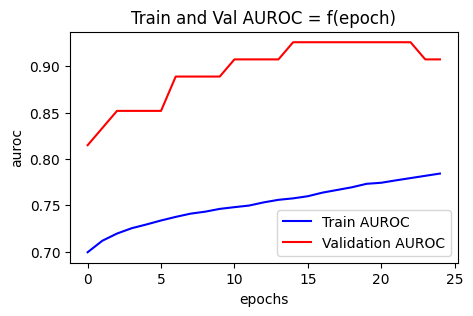

[       nan 0.         0.         0.         1.         0.21052632
 0.25490196 0.23636364 0.65217391 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


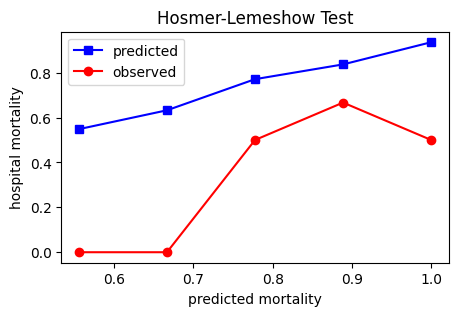

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.03s/it]

test AUROC: 0.7800
test Precision: 0.3333
test Recall: 1.0000
test Specificity: 0.0000
test Accuracy: 0.3333
test F1 Score: 0.5000
test HL Score: 17.3869
(160, 120, 12)
(160,)
tensor([2., 2.])


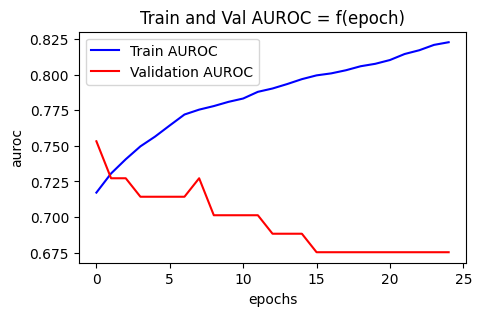

[       nan 0.17910448 0.35897436 0.44444444 0.6097561  0.
 0.         0.30120482 0.82692308 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


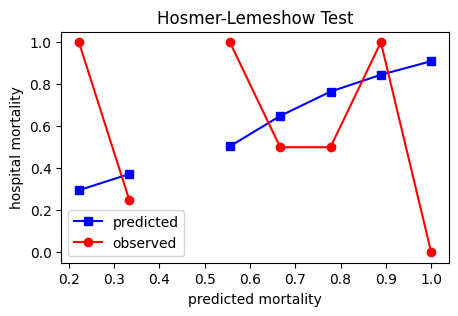

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:08<00:02,  1.02s/it]

test AUROC: 0.5536
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 15.8163
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


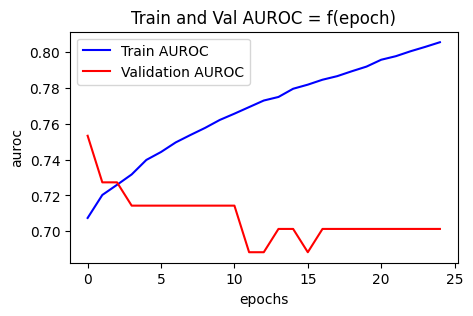

[       nan 0.         0.43859649 0.47169811 0.44444444 0.33333333
 0.         0.2688172  0.8372093  1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups


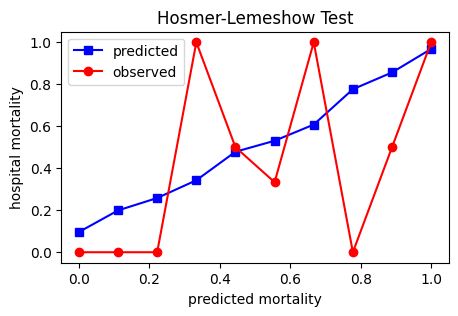


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:09<00:01,  1.00s/it]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 12.7675
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


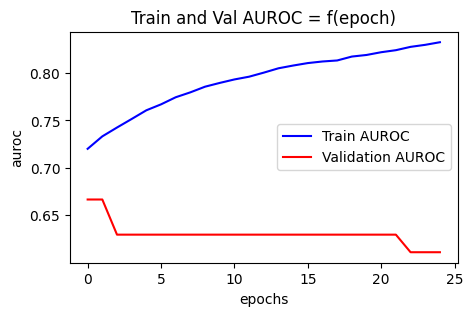

[0.         0.         0.         0.13043478 0.48275862 0.73333333
 0.5952381  0.         0.29069767 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


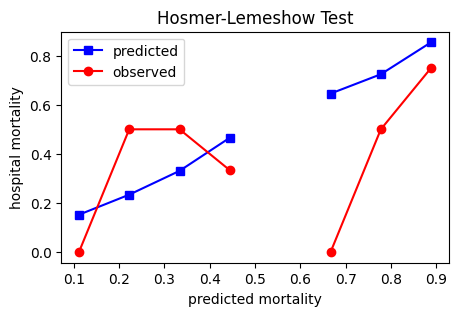

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:30<01:10, 10.10s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 6.2872
Mean AUROC: 0.7216
Mean Precision: 0.4185
Mean Recall: 0.8655
Mean Specificity: 0.2689
Mean Accuracy: 0.5144
Mean F1 Score: 0.5395
SD Auroc: 0.1261



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


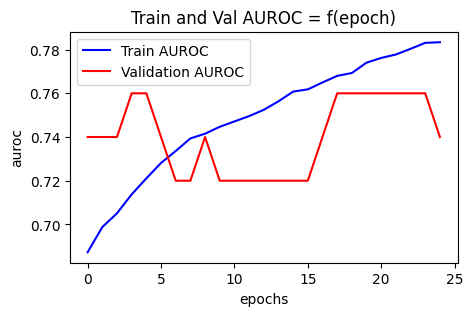

[       nan        nan        nan 0.         0.         0.
 0.36842105 0.59302326 0.37837838 0.56818182]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


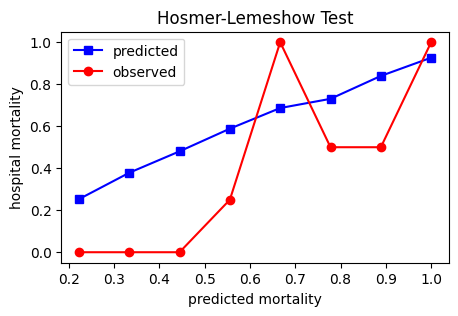

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.00it/s]

test AUROC: 0.8519
test Precision: 0.5455
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.6667
test F1 Score: 0.7059
test HL Score: 7.3421
(172, 120, 12)
(172,)
tensor([2.3243, 1.7551])


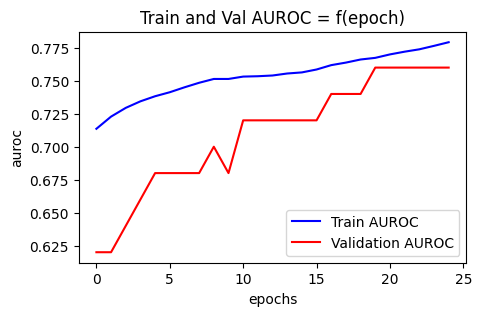

[       nan 0.         0.         0.         0.         0.
 0.30379747 0.32692308 0.57142857 0.50588235]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


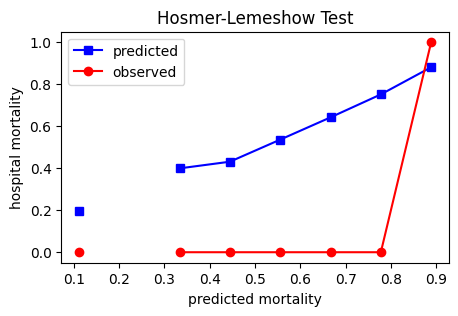

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.03s/it]

test AUROC: 1.0000
test Precision: 0.1000
test Recall: 1.0000
test Specificity: 0.3333
test Accuracy: 0.4000
test F1 Score: 0.1818
test HL Score: 21.3684
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


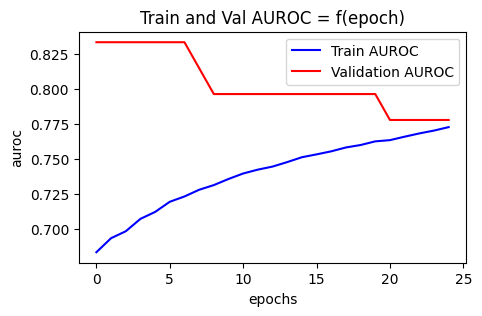

[       nan 0.         0.         0.         0.         0.16666667
 0.44642857 0.69014085 0.58108108 0.78125   ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


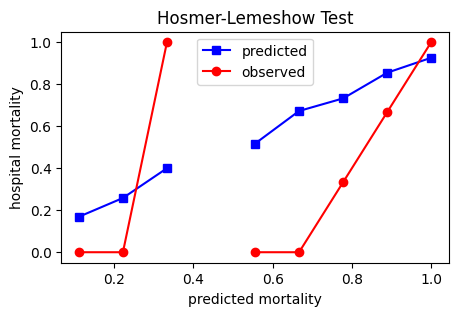

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.01s/it]

test AUROC: 0.7963
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 11.0315
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


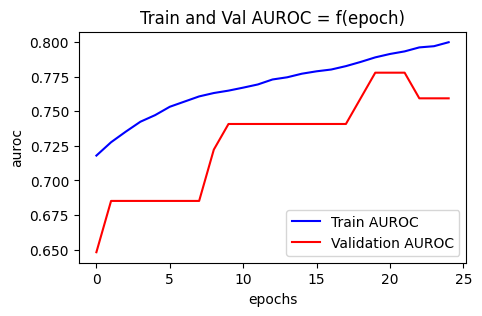

[0.         0.         0.         0.2        0.52941176 0.53271028
 1.         0.         0.56818182 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


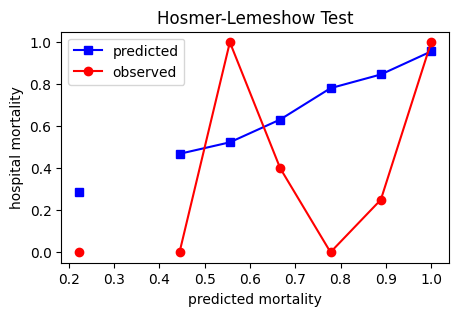

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.01s/it]

test AUROC: 0.6200
test Precision: 0.3846
test Recall: 1.0000
test Specificity: 0.1333
test Accuracy: 0.4667
test F1 Score: 0.5556
test HL Score: 21.4739
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


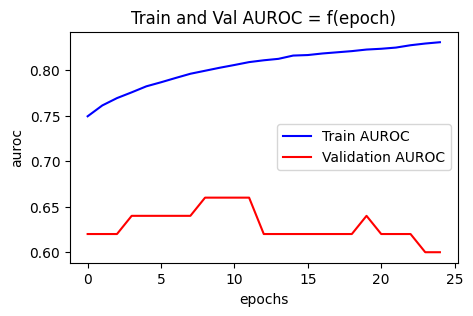

[       nan 0.         0.         0.0625     0.15151515 0.65882353
 0.52173913 0.         0.24509804 0.56818182]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


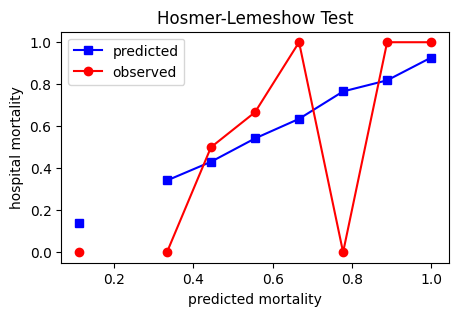

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.00s/it]

test AUROC: 0.6296
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 15.0131
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


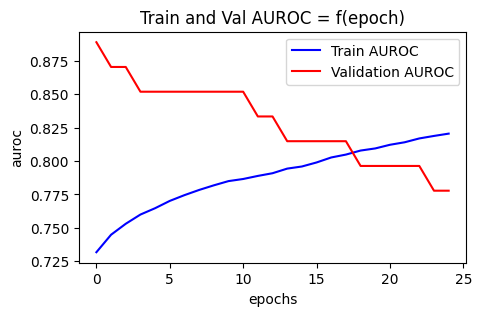

[       nan 0.         0.         0.         0.         0.
 0.34       0.65168539 0.57627119 0.74545455]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


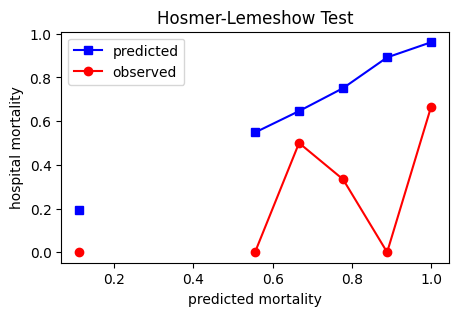

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:03,  1.00it/s]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 29.2355
(172, 120, 12)
(172,)
tensor([2.3243, 1.7551])


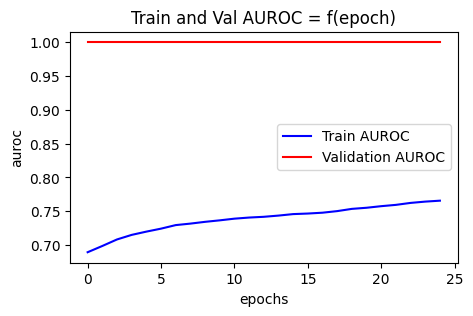

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.89285714        nan]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


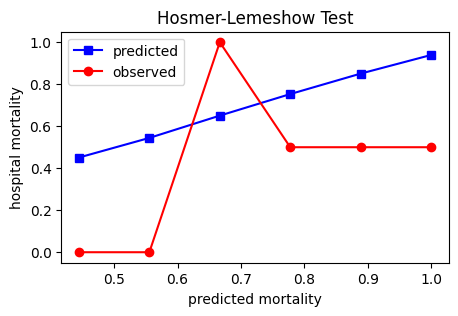

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.01s/it]

test AUROC: 0.7400
test Precision: 0.4167
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 17.9099
(164, 120, 12)
(164,)
tensor([2., 2.])


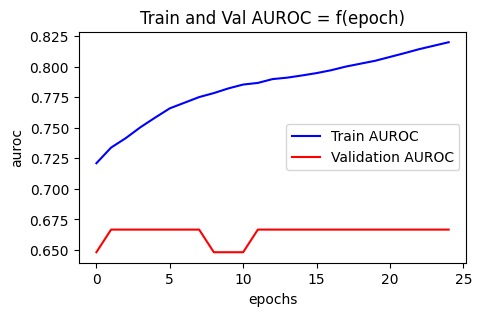

[0.         0.         0.         0.25       0.6344086  0.12903226
 1.         0.         0.390625   1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


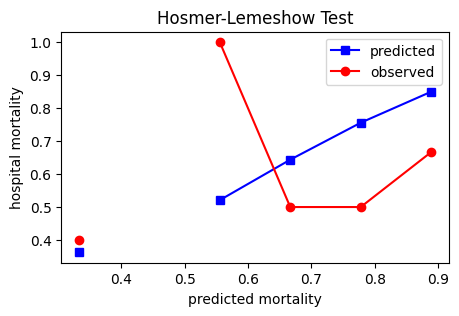

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:08<00:01,  1.00it/s]

test AUROC: 0.5357
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 3.3359
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


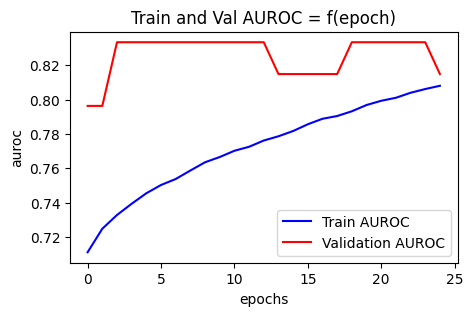

[       nan 0.         0.         0.02702703 1.         0.34210526
 0.         0.34090909 0.65289256 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


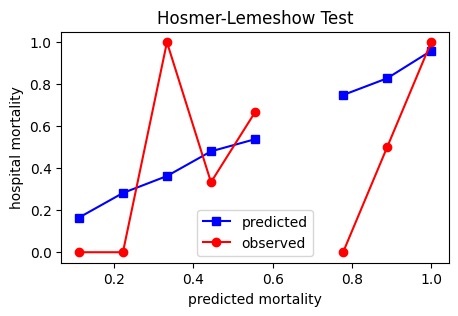

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:09<00:00,  1.01it/s]

test AUROC: 0.6667
test Precision: 0.5000
test Recall: 0.6667
test Specificity: 0.4667
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 10.5147
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


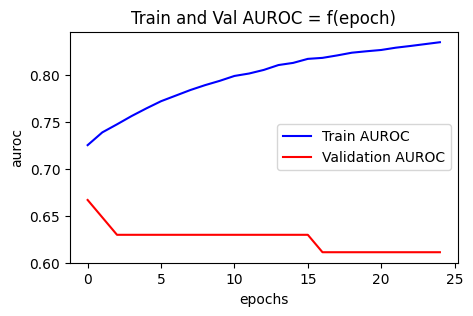

[0.         0.         0.         0.23529412 0.45588235 0.75471698
 0.54347826 0.         0.35714286 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


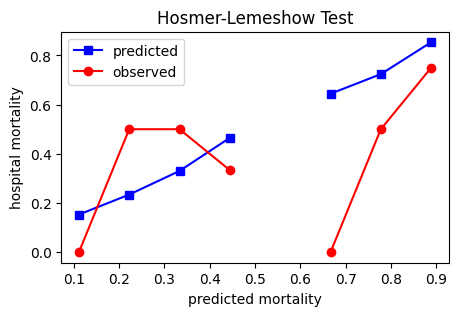

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:40<01:00, 10.06s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 6.2649
Mean AUROC: 0.7213
Mean Precision: 0.4358
Mean Recall: 0.8655
Mean Specificity: 0.2956
Mean Accuracy: 0.5411
Mean F1 Score: 0.5542
SD Auroc: 0.1296



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


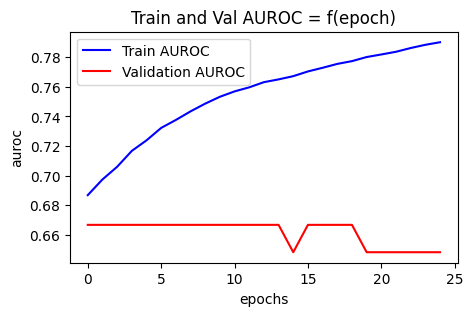

[       nan 0.         0.         0.11764706 0.35185185 0.69879518
 0.58333333 0.13793103 0.40677966 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


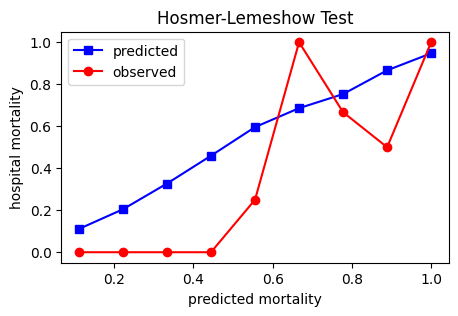

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.02it/s]

test AUROC: 0.8704
test Precision: 0.5455
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.6667
test F1 Score: 0.7059
test HL Score: 6.6520
(172, 120, 12)
(172,)
tensor([2.3243, 1.7551])


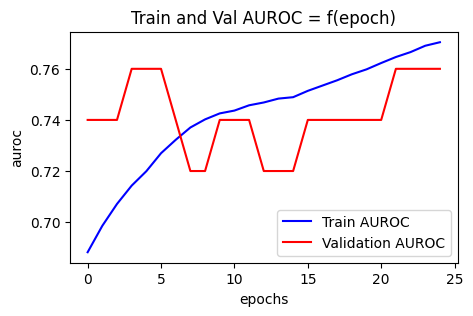

[       nan        nan        nan        nan 0.         0.
 0.33846154 0.51785714 0.43548387 0.62068966]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


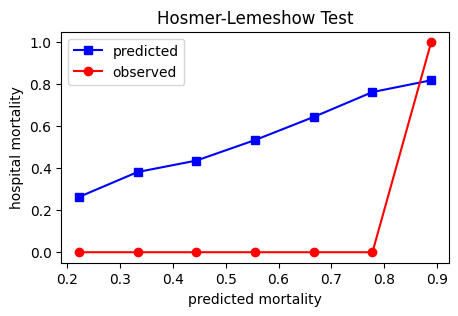

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:01<00:08,  1.00s/it]

test AUROC: 1.0000
test Precision: 0.1111
test Recall: 1.0000
test Specificity: 0.4000
test Accuracy: 0.4667
test F1 Score: 0.2000
test HL Score: 18.5078
(164, 120, 12)
(164,)
tensor([2., 2.])


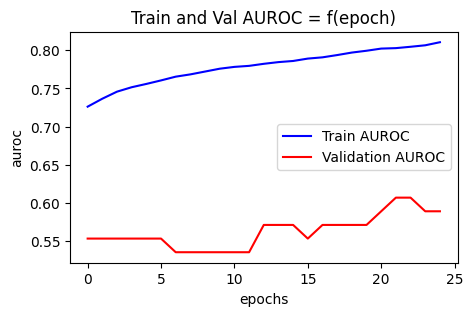

[       nan        nan 1.         0.44444444 0.4047619  0.58333333
 0.7037037  0.51724138 0.59166667 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


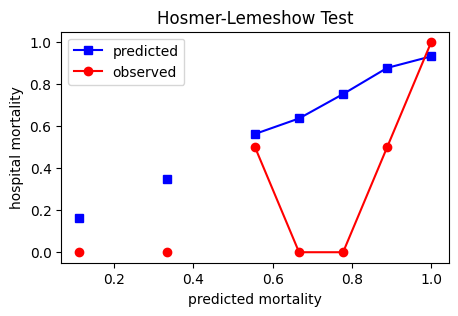

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:02<00:06,  1.01it/s]

test AUROC: 0.8704
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 14.6903
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


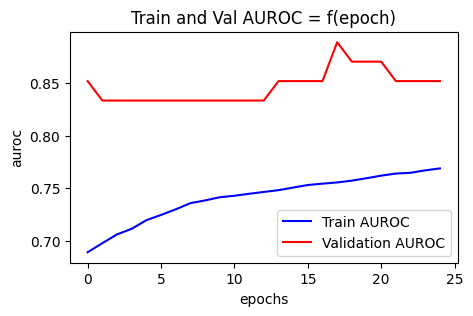

[       nan 0.         0.         0.         0.         0.1147541
 0.43283582 0.68181818 0.57377049 0.87179487]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


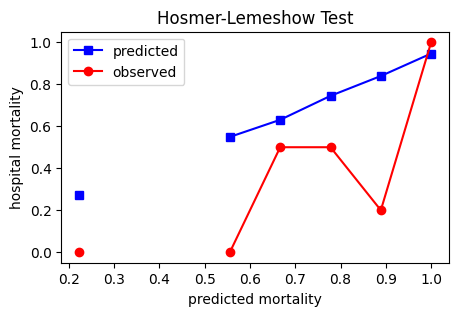

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:03<00:05,  1.01it/s]

test AUROC: 0.6400
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 18.9174
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


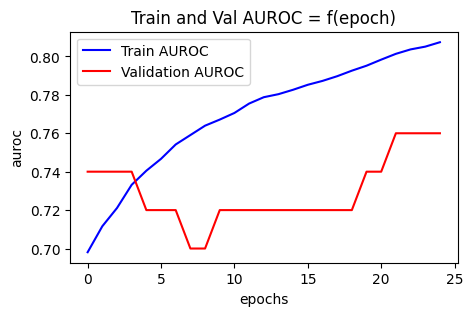

[       nan        nan        nan        nan 0.         0.
 0.48333333 0.62666667 0.34939759 0.52631579]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


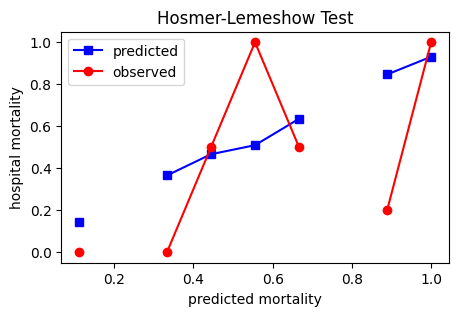

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:04<00:04,  1.01it/s]

test AUROC: 0.5926
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 19.1650
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


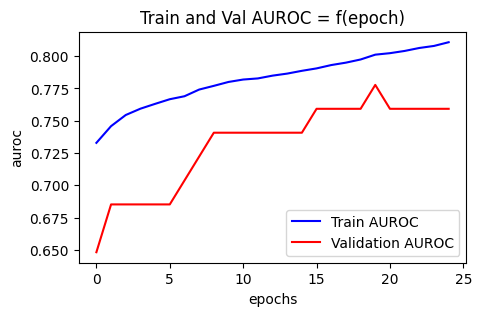

[0.         0.         0.         0.09302326 0.41304348 0.61904762
 1.         0.         0.32894737 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


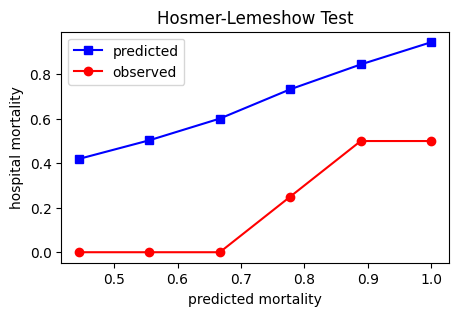

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:05<00:03,  1.01it/s]

test AUROC: 0.7800
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 26.6252
(168, 120, 12)
(168,)
tensor([2.1538, 1.8667])


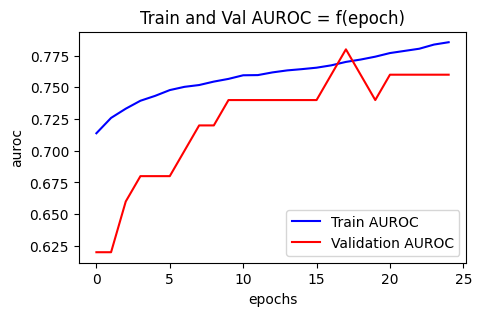

[       nan        nan 0.         0.         0.         0.
 0.24489796 0.32394366 0.55384615 0.5060241 ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


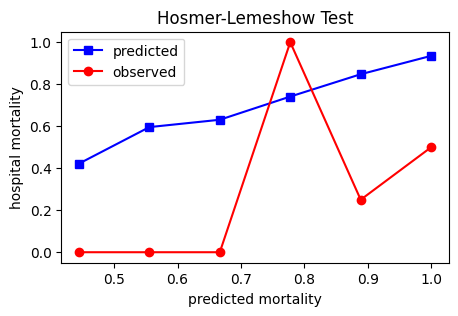

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:06<00:03,  1.00s/it]

test AUROC: 0.7200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 27.3821
(164, 120, 12)
(164,)
tensor([2., 2.])


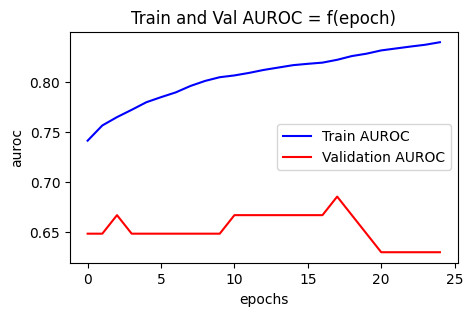

[0.         0.         0.         0.50684932 0.51428571 0.06896552
 1.         0.         0.30487805 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


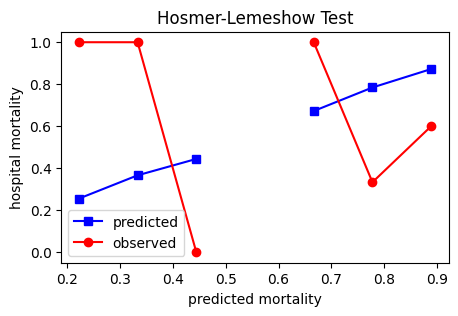

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:07<00:01,  1.01it/s]

test AUROC: 0.4821
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 14.9581
(164, 120, 12)
(164,)
tensor([2., 2.])


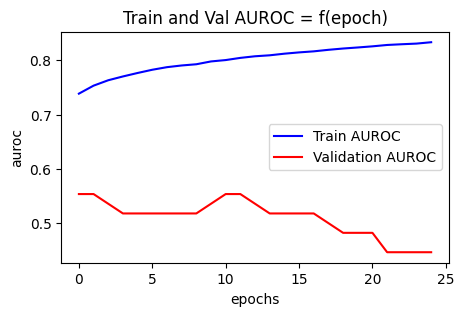

[       nan        nan 1.         0.6097561  0.         1.
 0.91304348 0.41666667 0.56910569 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups


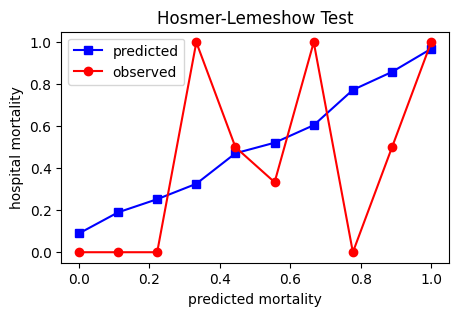


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:09<00:01,  1.08s/it]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 12.7859
(160, 120, 12)
(160,)
tensor([2., 2.])


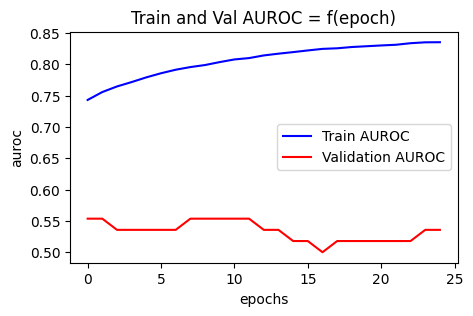

[       nan        nan 1.         0.52542373 0.375      0.32
 0.91666667 0.32142857 0.61073826 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


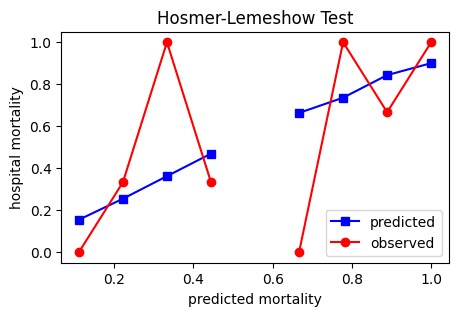

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:50<00:50, 10.11s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 9.7219
Mean AUROC: 0.7357
Mean Precision: 0.4272
Mean Recall: 0.8821
Mean Specificity: 0.2689
Mean Accuracy: 0.5278
Mean F1 Score: 0.5510
SD Auroc: 0.1450



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


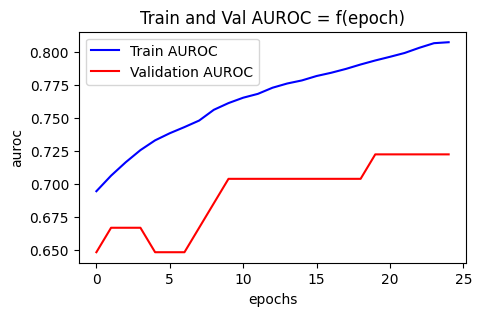

[0.         0.         0.         0.07692308 0.6119403  0.55555556
 1.         0.         0.53191489 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


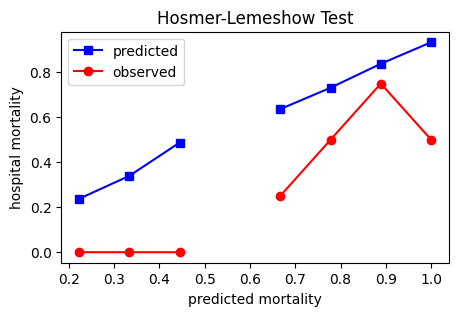

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.00it/s]

test AUROC: 0.8148
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 11.2061
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


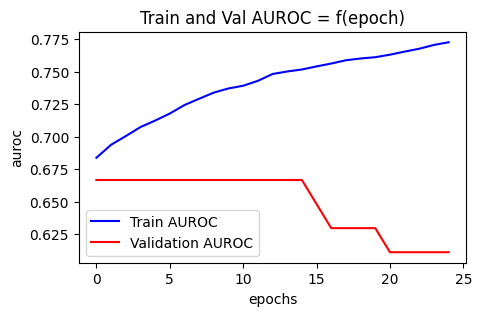

[       nan 0.         0.         0.07407407 0.66666667 0.61
 0.56756757 0.11666667 0.39285714 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


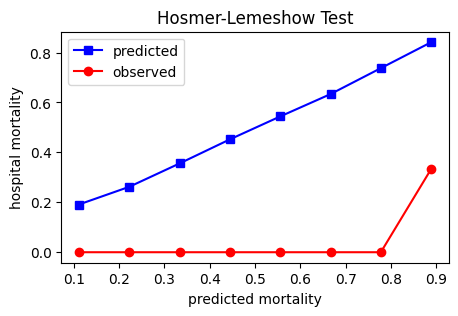

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.01s/it]

test AUROC: 1.0000
test Precision: 0.1250
test Recall: 1.0000
test Specificity: 0.4667
test Accuracy: 0.5333
test F1 Score: 0.2222
test HL Score: 17.8108
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


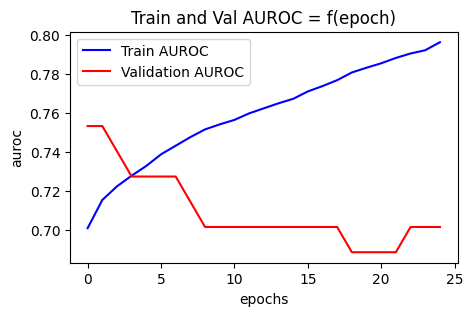

[       nan 0.         0.52083333 0.49019608 0.         0.42857143
 0.08510638 0.21126761 0.66666667 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


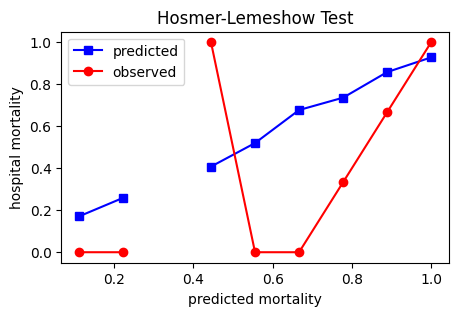

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:02<00:06,  1.01it/s]

test AUROC: 0.7963
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 11.1884
(168, 120, 12)
(168,)
tensor([2.1538, 1.8667])


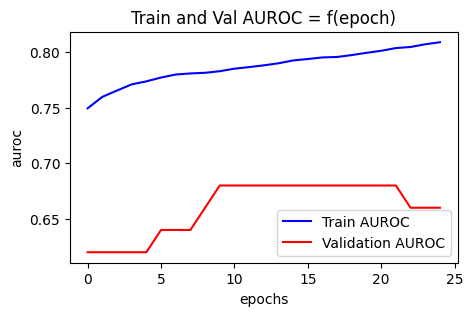

[       nan 0.         0.                nan        nan 0.
 0.51546392 0.06896552 0.48837209 0.5       ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


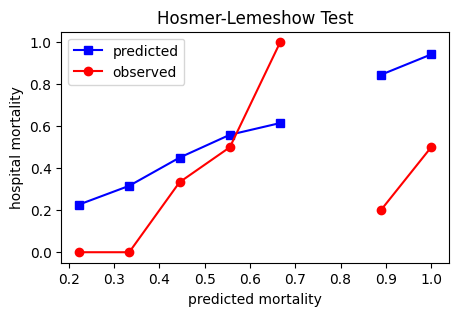

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:03<00:05,  1.00it/s]

test AUROC: 0.6200
test Precision: 0.4000
test Recall: 0.8000
test Specificity: 0.3333
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 24.5582
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


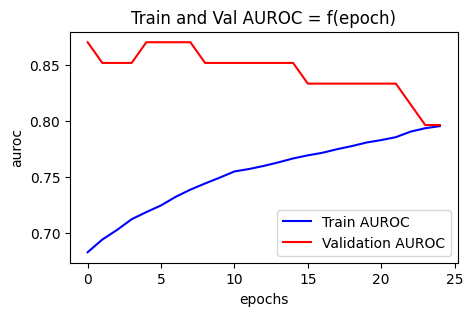

[       nan 0.         0.         0.         0.         0.06976744
 0.54666667 0.66197183 0.45098039 0.8372093 ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


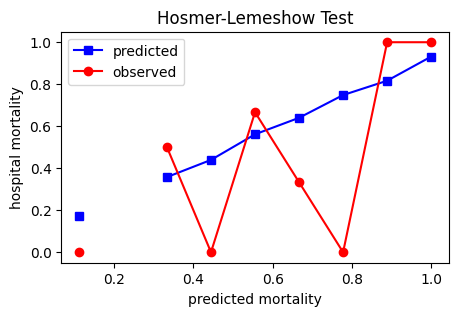

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:04<00:04,  1.01it/s]

test AUROC: 0.6667
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 8.9913
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


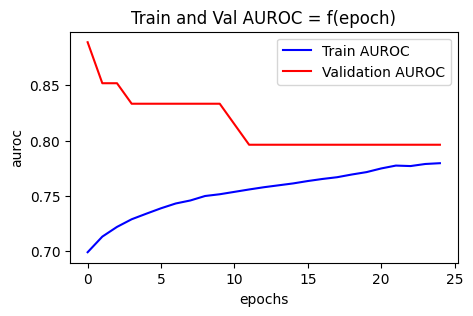

[       nan 0.         0.         0.         0.         0.07272727
 0.48076923 0.63636364 0.63513514 0.67567568]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


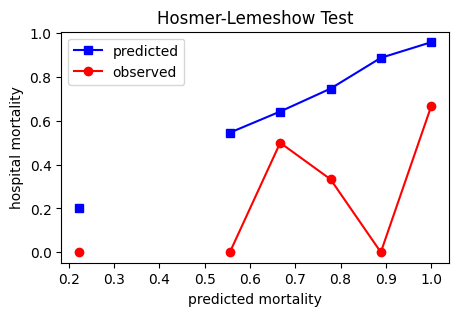

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:05<00:03,  1.01it/s]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 28.2651
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


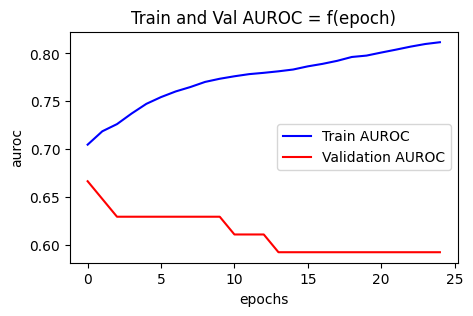

[       nan 0.         0.         0.10714286 0.46808511 0.74025974
 0.48648649 0.18367347 0.33333333 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


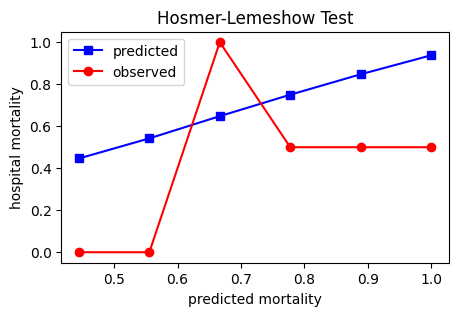

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:06<00:02,  1.01it/s]

test AUROC: 0.7400
test Precision: 0.4167
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 17.4773
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


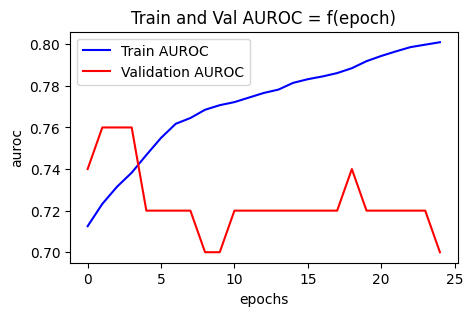

[       nan        nan        nan 0.         0.         0.0106383
 0.53703704 0.5        0.34482759 0.91304348]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


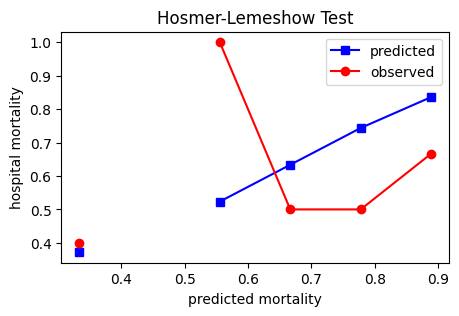

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:07<00:01,  1.01it/s]

test AUROC: 0.5357
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 2.9517
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


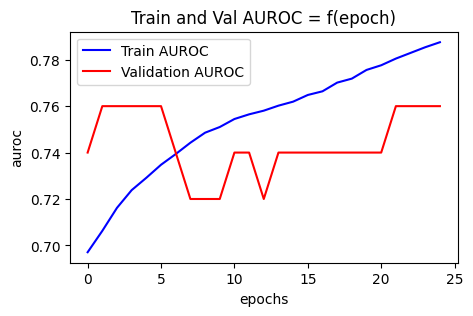

[       nan        nan        nan        nan 0.         0.
 0.27777778 0.70588235 0.37       0.54347826]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


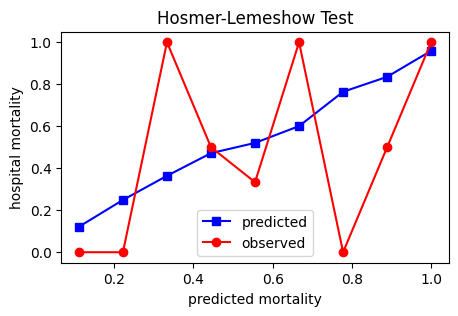

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:08<00:00,  1.01it/s]

test AUROC: 0.6852
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 11.7950
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


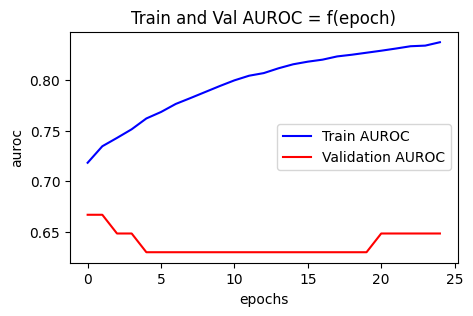

[0.         0.         0.         0.25       0.42424242 0.73469388
 0.61538462 0.         0.27419355 0.91666667]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


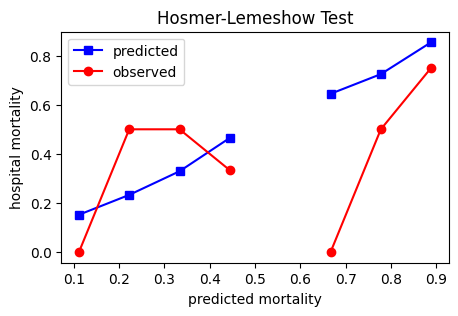

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [01:00<00:40, 10.03s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 6.2848
Mean AUROC: 0.7232
Mean Precision: 0.4298
Mean Recall: 0.8455
Mean Specificity: 0.3156
Mean Accuracy: 0.5478
Mean F1 Score: 0.5483
SD Auroc: 0.1235



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


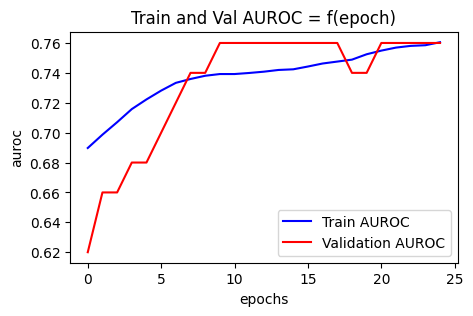

[       nan        nan 0.         0.         0.         0.
 0.29268293 0.22641509 0.7037037  0.51315789]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


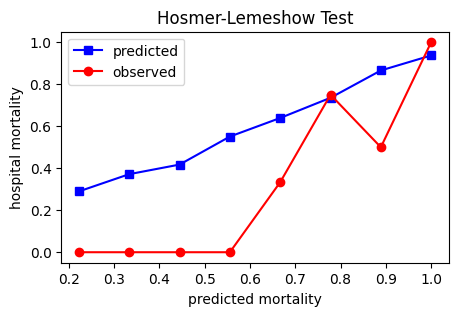

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:01<00:09,  1.02s/it]

test AUROC: 0.8519
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 7.7512
(167, 120, 12)
(167,)
tensor([2.2877, 1.7766])


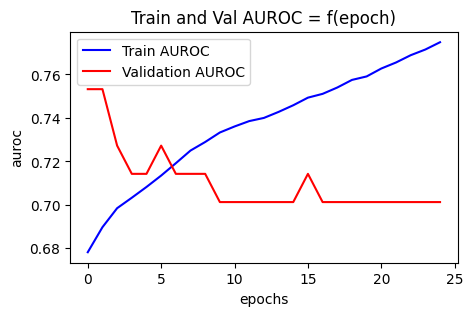

[       nan 0.         0.30487805 0.625      0.17142857 0.30434783
 0.10869565 0.25252525 0.90384615 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


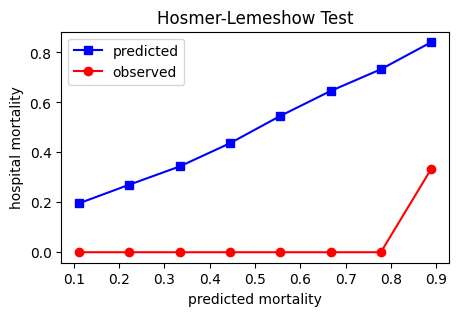

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.02s/it]

test AUROC: 1.0000
test Precision: 0.1250
test Recall: 1.0000
test Specificity: 0.4667
test Accuracy: 0.5333
test F1 Score: 0.2222
test HL Score: 17.9359
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


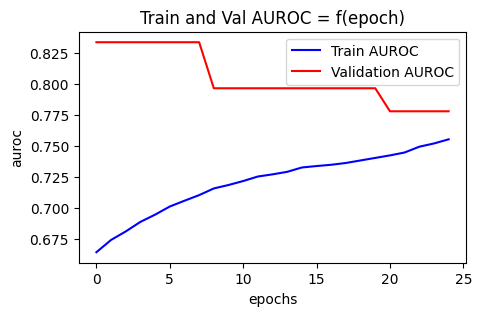

[       nan 0.         0.         0.         0.         0.18644068
 0.42307692 0.70588235 0.58227848 0.85185185]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


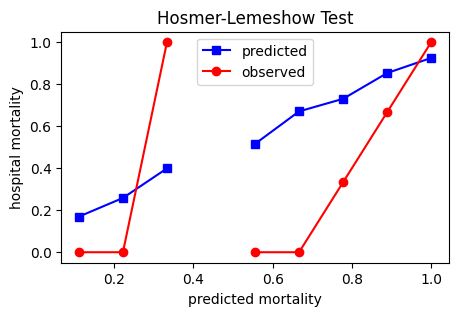

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.00s/it]

test AUROC: 0.7963
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 10.9433
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


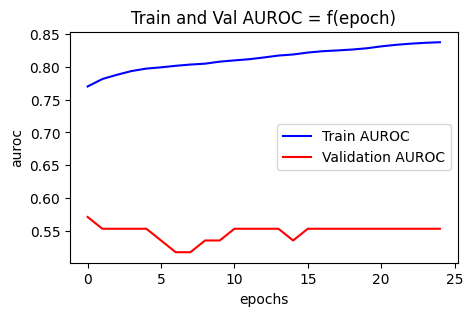

[       nan        nan 1.         0.515625   0.27868852 1.
 0.80952381 0.42253521 0.61594203 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


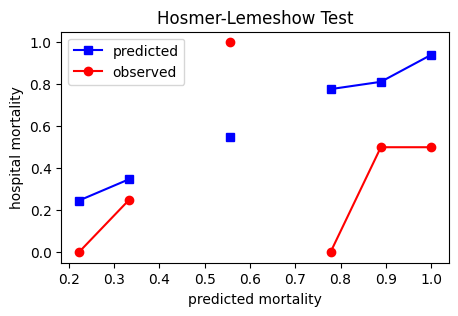

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:05,  1.00it/s]

test AUROC: 0.6200
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 21.0148
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


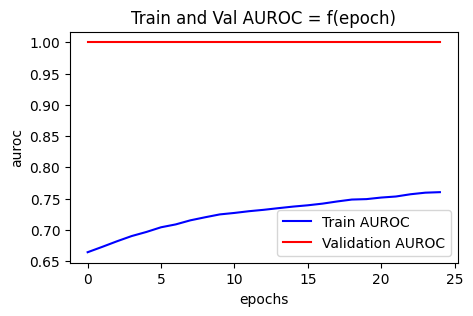

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.89285714        nan]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


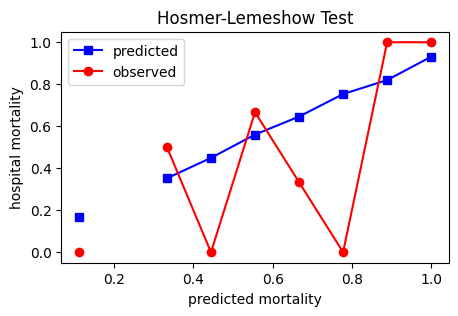

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.01s/it]

test AUROC: 0.6667
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 9.2232
(168, 120, 12)
(168,)
tensor([2.1538, 1.8667])


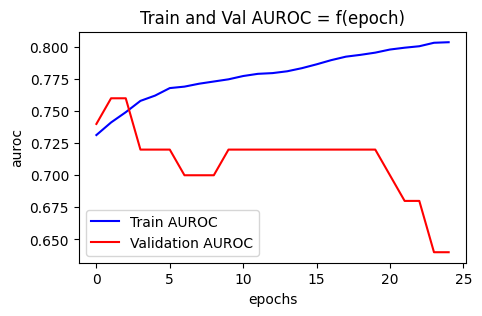

[       nan        nan        nan 0.         0.         0.01149425
 0.43333333 0.81967213 0.25       0.55555556]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


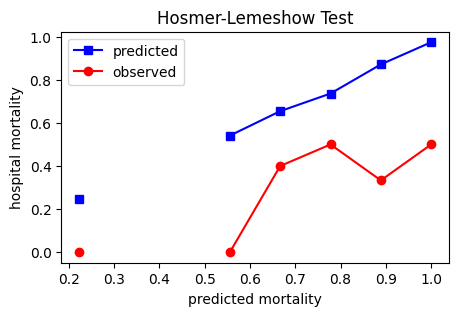

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.01s/it]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 30.3757
(163, 120, 12)
(163,)
tensor([2.1169, 1.8953])


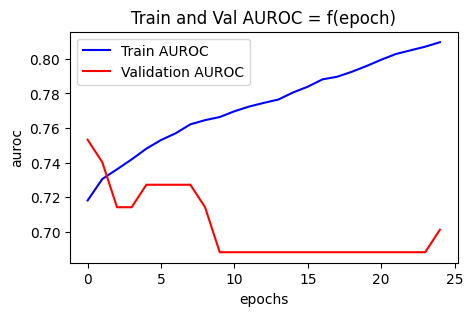

[       nan 0.         0.3968254  0.56818182 0.24324324 0.41935484
 0.07894737 0.24210526 0.55319149 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


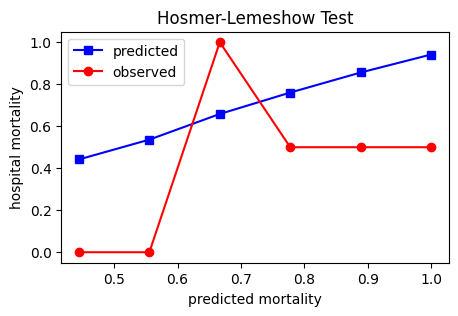

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.00s/it]

test AUROC: 0.7400
test Precision: 0.3846
test Recall: 1.0000
test Specificity: 0.1333
test Accuracy: 0.4667
test F1 Score: 0.5556
test HL Score: 18.6520
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


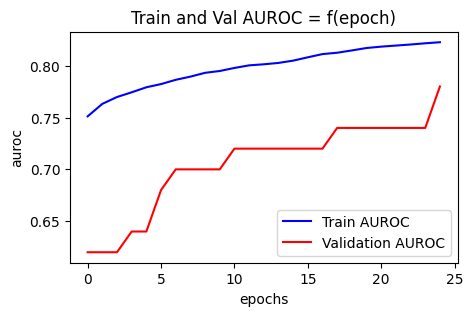

[       nan 0.         0.         0.         0.         0.
 0.28571429 0.41975309 0.36538462 0.53191489]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


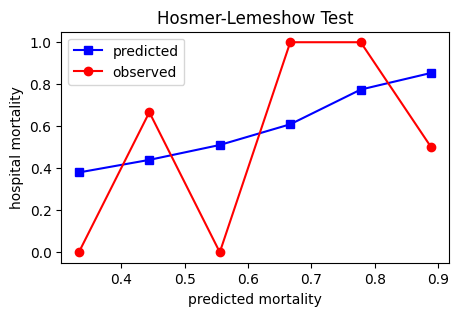

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:08<00:01,  1.00it/s]

test AUROC: 0.5179
test Precision: 0.5455
test Recall: 0.7500
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.6316
test HL Score: 11.2388
(164, 120, 12)
(164,)
tensor([2., 2.])


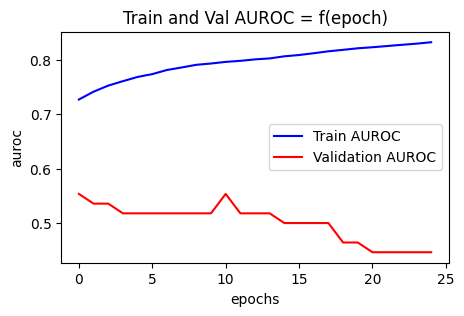

[       nan        nan 1.         0.89090909 0.         1.
 0.91489362 0.41025641 0.58119658 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups


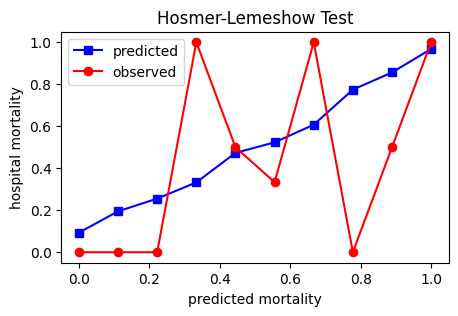


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:08<00:00,  1.02it/s]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 12.7312
(162, 120, 12)
(162,)
tensor([2.0769, 1.9286])


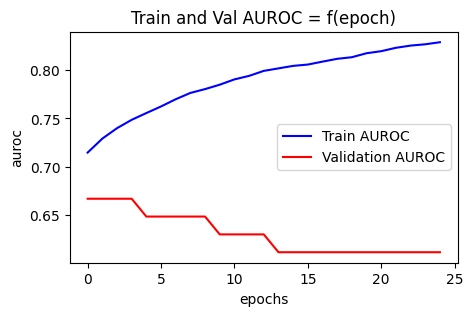

[0.         0.         0.         0.4        0.33870968 0.66666667
 0.71428571 0.         0.25       1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


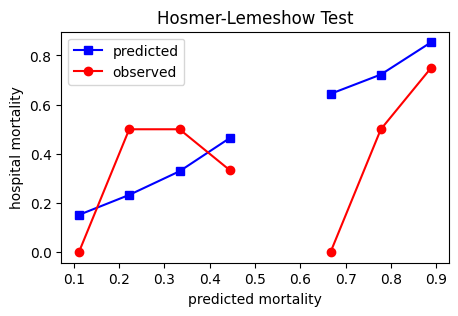

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [01:10<00:30, 10.01s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 6.2631
Mean AUROC: 0.7214
Mean Precision: 0.4256
Mean Recall: 0.8455
Mean Specificity: 0.3089
Mean Accuracy: 0.5411
Mean F1 Score: 0.5454
SD Auroc: 0.1311



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


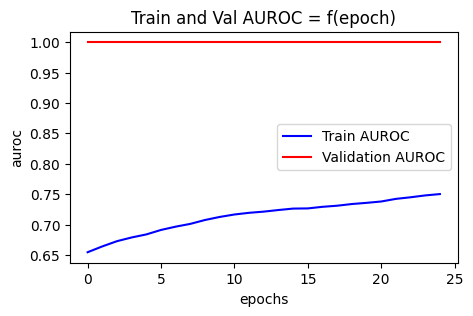

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.73529412        nan]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


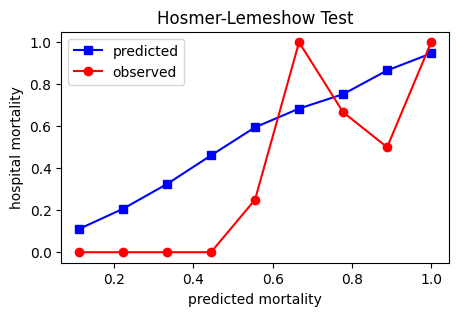

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:01<00:09,  1.03s/it]

test AUROC: 0.8519
test Precision: 0.5455
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.6667
test F1 Score: 0.7059
test HL Score: 6.6307
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


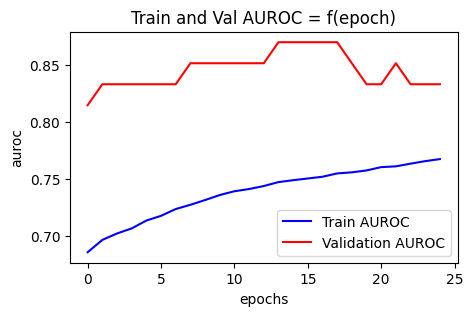

[       nan 0.         0.         0.         0.38461538 0.30952381
 0.14285714 0.18       0.64285714 0.95652174]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


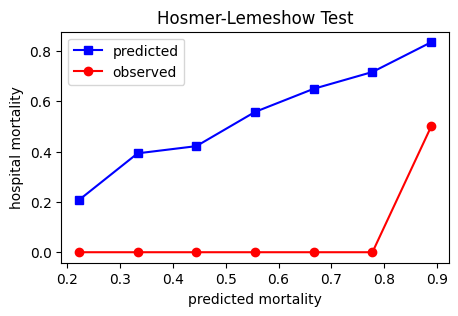

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.02s/it]

test AUROC: 1.0000
test Precision: 0.1000
test Recall: 1.0000
test Specificity: 0.3333
test Accuracy: 0.4000
test F1 Score: 0.1818
test HL Score: 17.9205
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


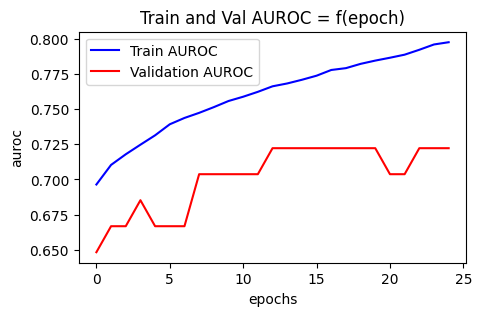

[0.         0.         0.         0.41666667 0.47692308 0.53571429
 1.         0.01818182 0.53333333 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


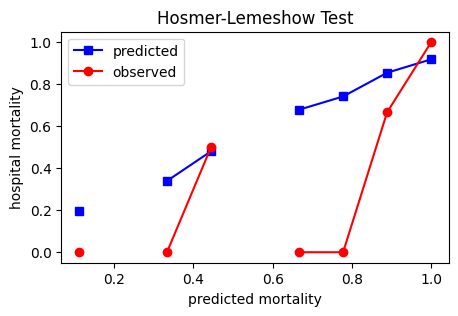

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.01s/it]

test AUROC: 0.8148
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 10.1648
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


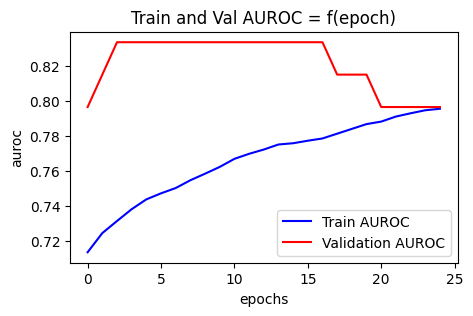

[       nan 0.         0.         0.08333333 0.57142857 0.33333333
 0.         0.21568627 0.66666667 0.77966102]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


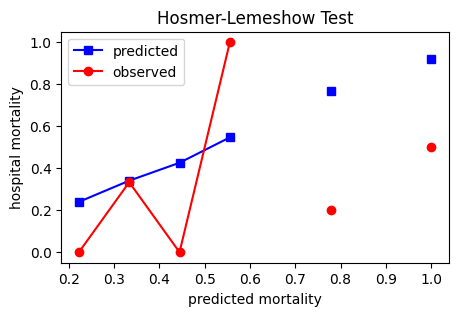

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.01s/it]

test AUROC: 0.6400
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 17.0909
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


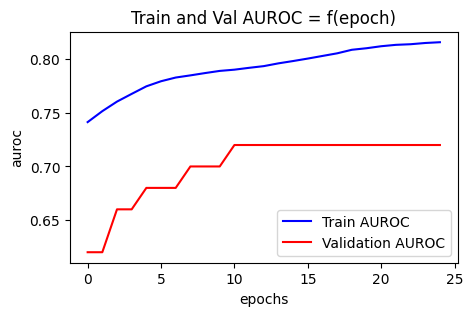

[       nan 0.         0.         0.         0.         0.
 0.50877193 0.11711712 0.70909091 0.5       ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


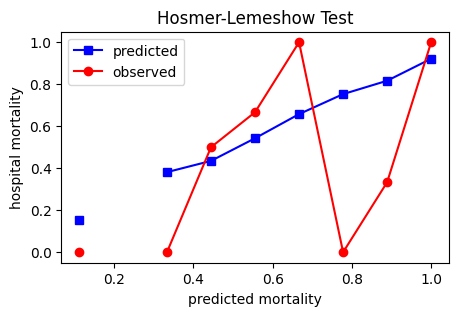

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.11s/it]

test AUROC: 0.6296
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 12.5796
(163, 120, 12)
(163,)
tensor([2.1169, 1.8953])


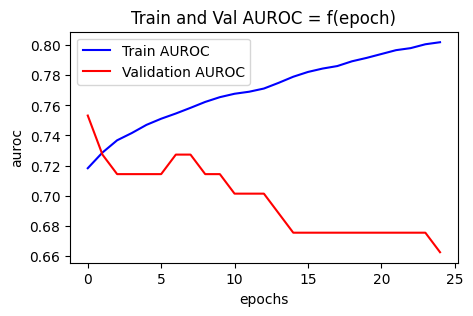

[       nan 0.09459459 0.54545455 0.5        0.58064516 0.24137931
 0.         0.29761905 0.35294118 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


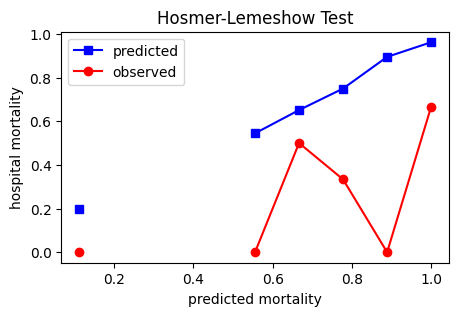

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.07s/it]

test AUROC: 0.6200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 29.8871
(168, 120, 12)
(168,)
tensor([2.1538, 1.8667])


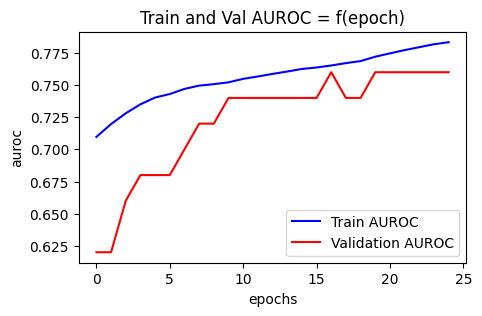

[       nan        nan 0.         0.         0.         0.
 0.27472527 0.29166667 0.53623188 0.5060241 ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


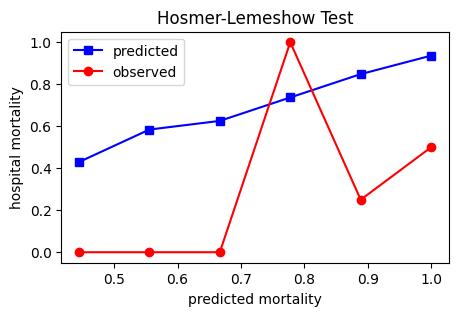

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.05s/it]

test AUROC: 0.7200
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 27.3863
(160, 120, 12)
(160,)
tensor([2., 2.])


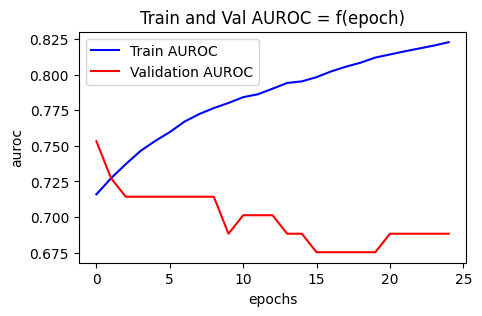

[       nan 0.2027027  0.37837838 0.41176471 0.6097561  0.
 0.         0.29761905 0.75609756 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


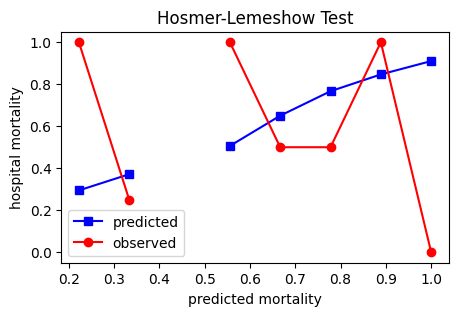

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:08<00:02,  1.03s/it]

test AUROC: 0.5536
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 15.9235
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


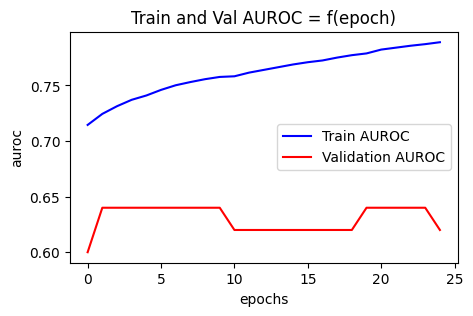

[       nan        nan 0.         0.23076923 0.22       0.43076923
 0.68421053 0.13402062 0.33928571 0.86206897]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


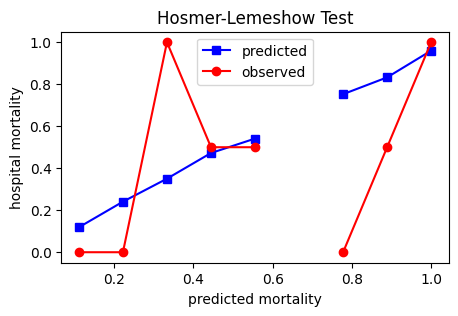

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:09<00:01,  1.02s/it]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 10.3706
(160, 120, 12)
(160,)
tensor([2., 2.])


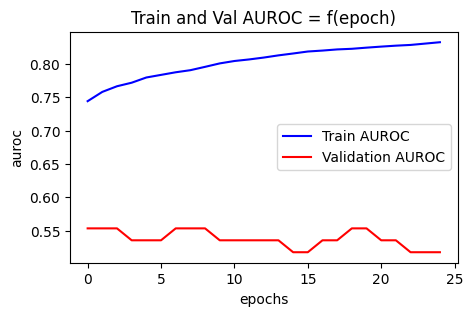

[       nan        nan 1.         0.60784314 0.28125    0.47058824
 0.90322581 0.3877551  0.59375    0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


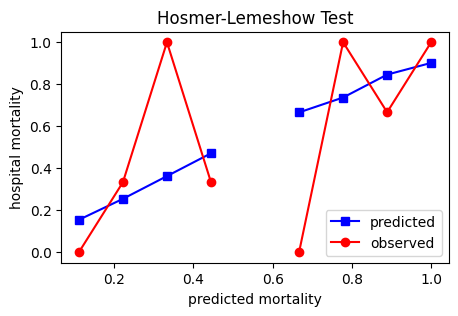

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [01:20<00:20, 10.10s/it]

test AUROC: 0.7532
test Precision: 0.5000
test Recall: 0.5714
test Specificity: 0.5556
test Accuracy: 0.6111
test F1 Score: 0.5333
test HL Score: 9.8157
Mean AUROC: 0.7231
Mean Precision: 0.4349
Mean Recall: 0.8455
Mean Specificity: 0.3089
Mean Accuracy: 0.5411
Mean F1 Score: 0.5495
SD Auroc: 0.1278



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


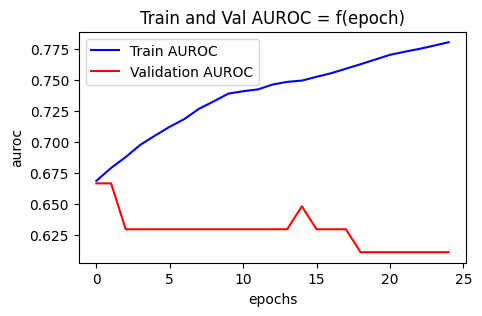

[       nan 0.         0.         0.07692308 0.50943396 0.75342466
 0.38095238 0.18644068 0.41071429 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


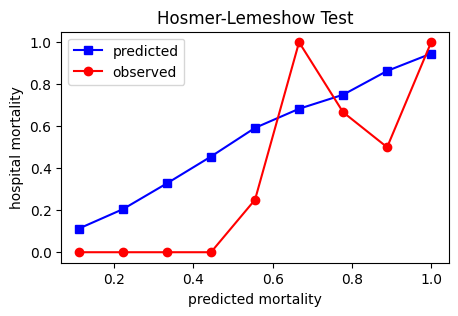

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.01it/s]

test AUROC: 0.8704
test Precision: 0.5455
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.6667
test F1 Score: 0.7059
test HL Score: 6.5178
(172, 120, 12)
(172,)
tensor([2.3243, 1.7551])


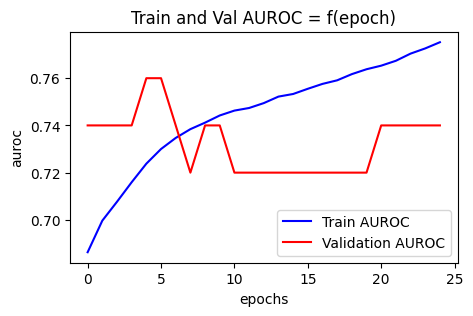

[       nan        nan        nan 0.         0.         0.
 0.41176471 0.6746988  0.32926829 0.53846154]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


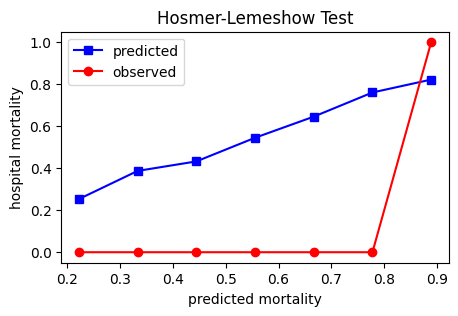

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.01s/it]

test AUROC: 1.0000
test Precision: 0.1111
test Recall: 1.0000
test Specificity: 0.4000
test Accuracy: 0.4667
test F1 Score: 0.2000
test HL Score: 18.6039
(166, 120, 12)
(166,)
tensor([2.0750, 1.9302])


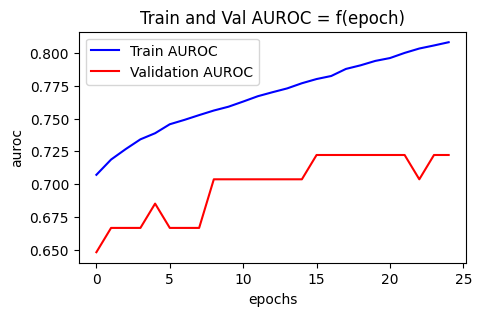

[0.         0.         0.         0.12195122 0.55844156 0.55
 1.         0.         0.44642857 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


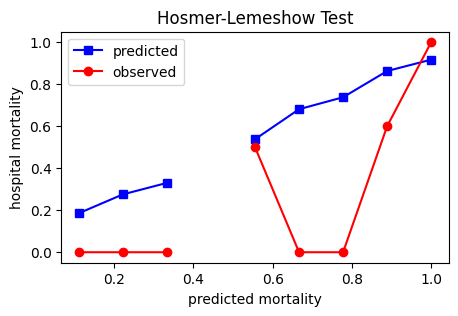

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.01s/it]

test AUROC: 0.8704
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 11.2981
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


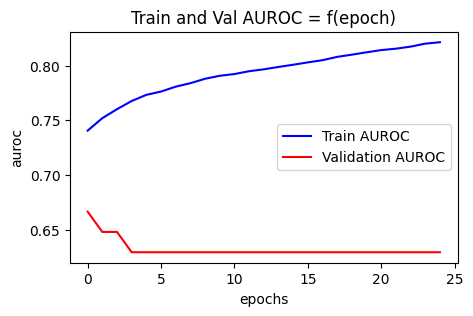

[0.         0.         0.         0.16666667 0.44444444 0.74626866
 0.5952381  0.         0.35714286 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


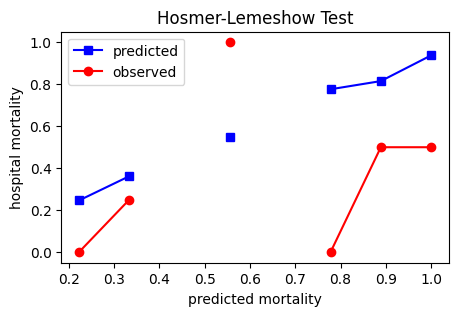

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.00s/it]

test AUROC: 0.6200
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 20.7410
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


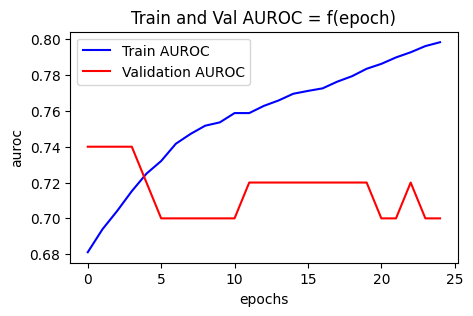

[       nan        nan        nan 0.         0.         0.
 0.625      0.46153846 0.38666667 0.55555556]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


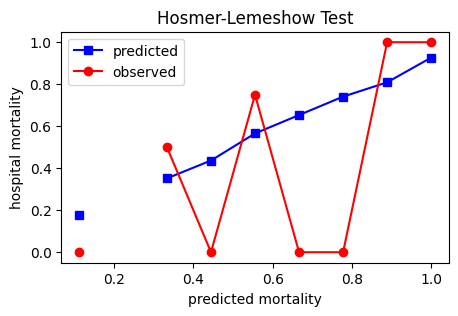

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.00s/it]

test AUROC: 0.6667
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 11.7478
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


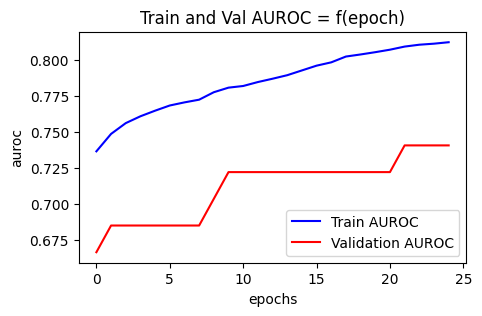

[0.         0.         0.         0.25       0.46153846 0.58974359
 0.92592593 0.         0.36231884 1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


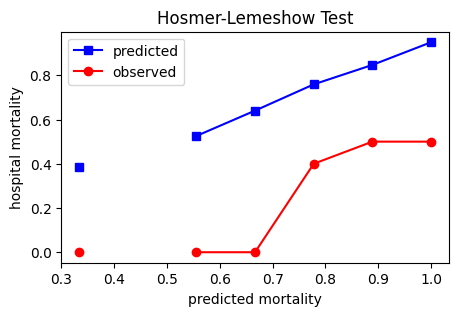

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.00s/it]

test AUROC: 0.7600
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 27.4918
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


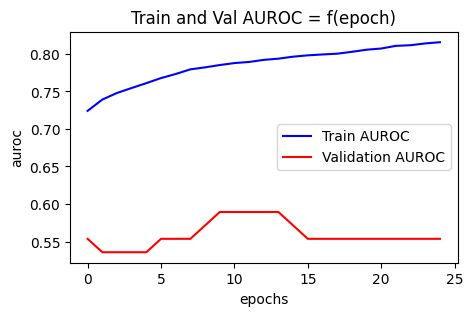

[       nan        nan 1.         0.36956522 0.50793651 0.45
 0.80434783 0.37333333 0.61788618 0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


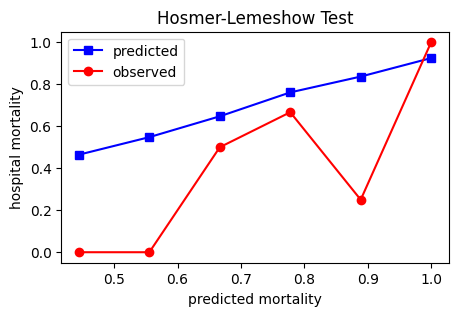

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:02,  1.00it/s]

test AUROC: 0.7000
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 16.1913
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


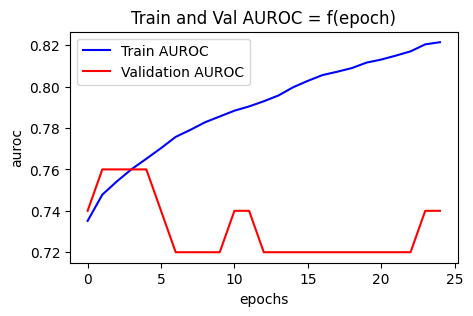

[       nan        nan        nan 0.         0.         0.
 0.32432432 0.75       0.34343434 0.54347826]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


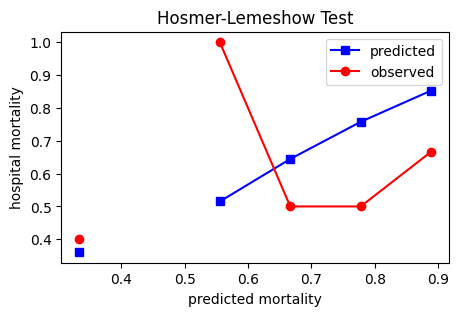

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:07<00:01,  1.00it/s]

test AUROC: 0.5357
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 3.4318
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


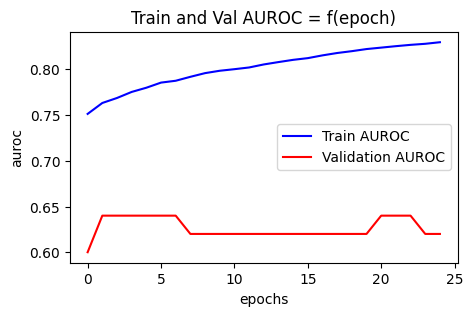

[       nan        nan 0.         0.2173913  0.32786885 0.25
 0.79411765 0.15492958 0.32894737 0.64102564]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


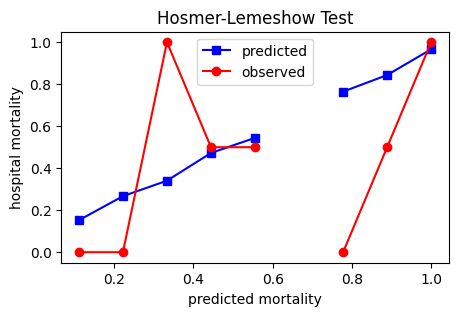

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:08<00:00,  1.00it/s]

test AUROC: 0.6481
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 11.0217
(163, 120, 12)
(163,)
tensor([2.1169, 1.8953])


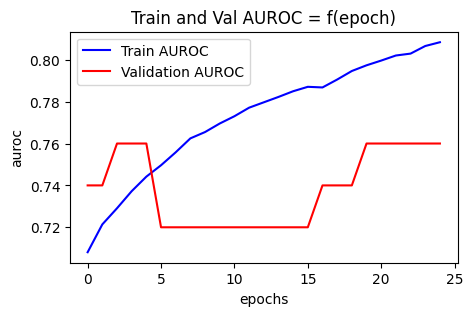

[       nan        nan        nan 0.         0.         0.
 0.18965517 0.76271186 0.41121495 0.5       ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


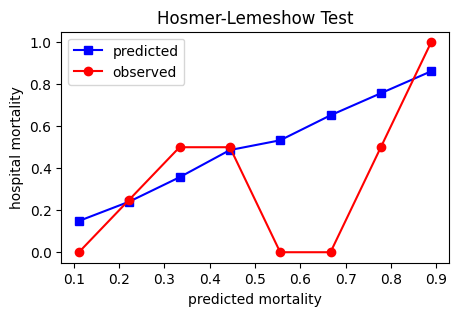

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [01:30<00:10, 10.07s/it]

test AUROC: 0.7143
test Precision: 0.4444
test Recall: 0.5714
test Specificity: 0.5000
test Accuracy: 0.5556
test F1 Score: 0.5000
test HL Score: 8.3191
Mean AUROC: 0.7386
Mean Precision: 0.4304
Mean Recall: 0.8621
Mean Specificity: 0.2967
Mean Accuracy: 0.5422
Mean F1 Score: 0.5522
SD Auroc: 0.1320



  0%|                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

(164, 120, 12)
(164,)
tensor([2., 2.])


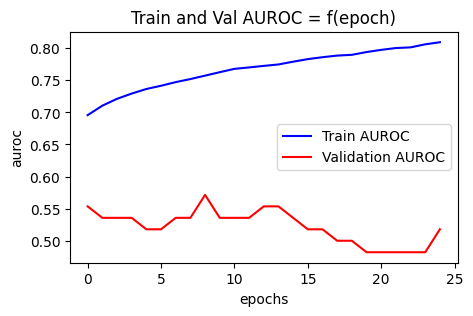

[       nan        nan 1.         0.86842105 0.24242424 0.41176471
 0.78125    0.48543689 0.61       0.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


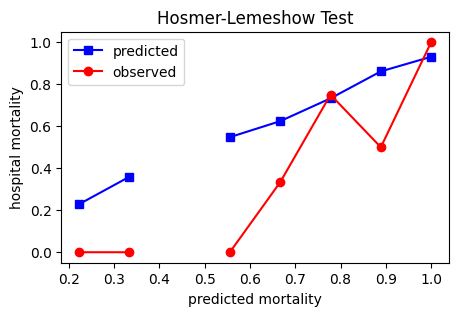

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 10%|███████████████▉                                                                                                                                               | 1/10 [00:00<00:08,  1.01it/s]

test AUROC: 0.8148
test Precision: 0.5000
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 7.1812
(172, 120, 12)
(172,)
tensor([2.3243, 1.7551])


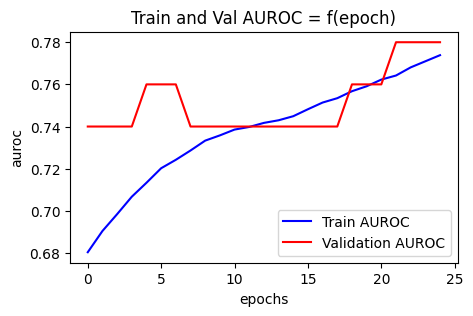

[       nan        nan        nan        nan 0.         0.
 0.31884058 0.51327434 0.48275862 0.53125   ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


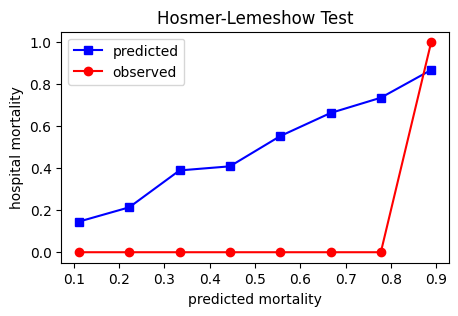

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 20%|███████████████████████████████▊                                                                                                                               | 2/10 [00:02<00:08,  1.02s/it]

test AUROC: 1.0000
test Precision: 0.0909
test Recall: 1.0000
test Specificity: 0.2667
test Accuracy: 0.3333
test F1 Score: 0.1667
test HL Score: 21.8544
(171, 120, 12)
(171,)
tensor([2.2800, 1.7812])


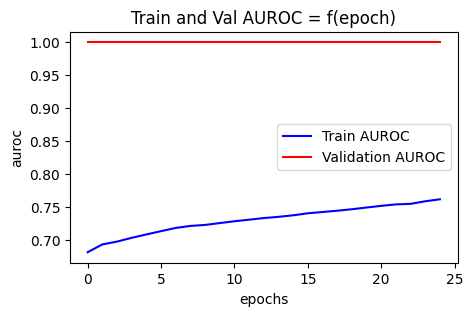

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.58139535        nan]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


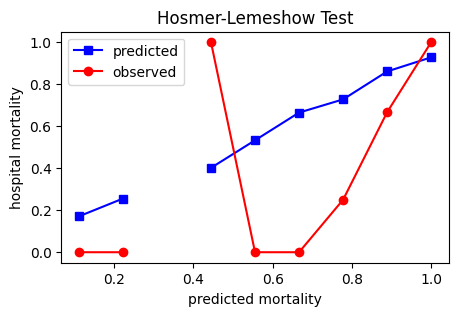

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [00:03<00:07,  1.03s/it]

test AUROC: 0.8148
test Precision: 0.4545
test Recall: 0.8333
test Specificity: 0.2667
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 11.2152
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


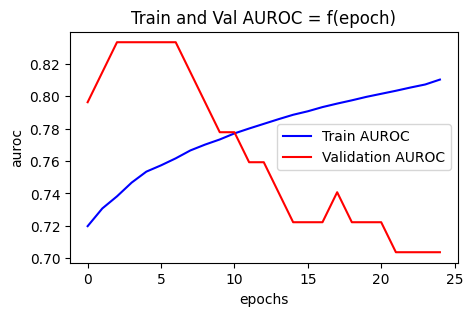

[       nan 0.         0.         0.03225806 0.58536585 0.
 0.         0.3        0.70338983 0.57692308]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


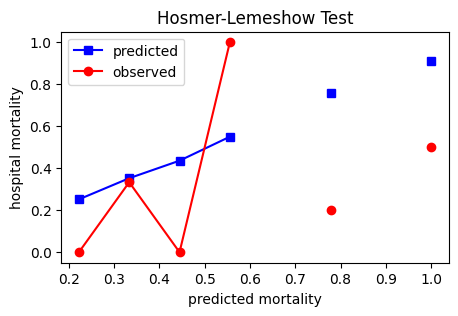

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 4/10 [00:04<00:06,  1.02s/it]

test AUROC: 0.6200
test Precision: 0.4444
test Recall: 0.8000
test Specificity: 0.4000
test Accuracy: 0.6000
test F1 Score: 0.5714
test HL Score: 16.3132
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


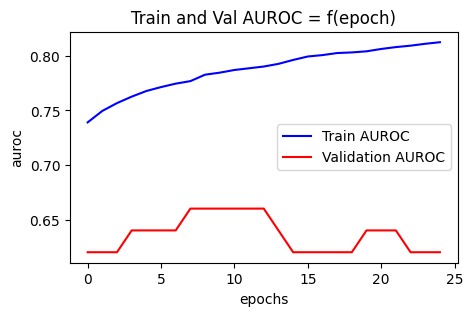

[       nan 0.         0.         0.06666667 0.13888889 0.57575758
 0.73170732 0.         0.23809524 0.55555556]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


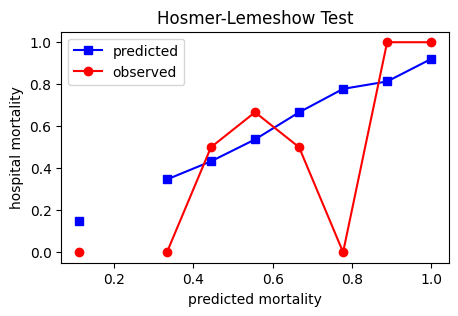

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 5/10 [00:05<00:05,  1.01s/it]

test AUROC: 0.6296
test Precision: 0.5000
test Recall: 0.8333
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6250
test HL Score: 12.1919
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


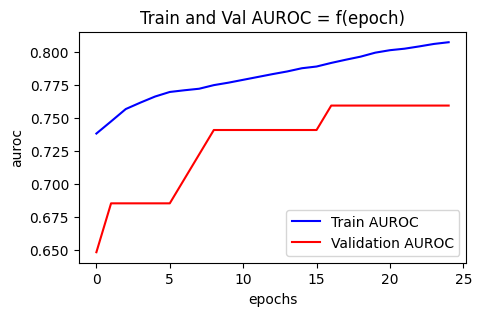

[0.         0.         0.         0.08823529 0.40425532 0.61627907
 1.         0.         0.3968254  1.        ]


/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


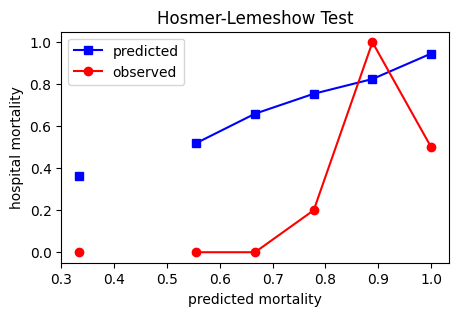

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6/10 [00:06<00:04,  1.01s/it]

test AUROC: 0.7600
test Precision: 0.3571
test Recall: 1.0000
test Specificity: 0.0667
test Accuracy: 0.4000
test F1 Score: 0.5263
test HL Score: 29.8266
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


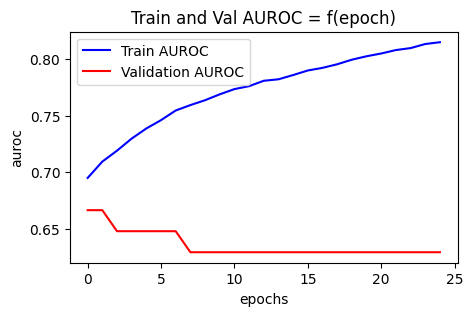

[       nan 0.         0.         0.13793103 0.45652174 0.6875
 0.60606061 0.125      0.32467532 1.        ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


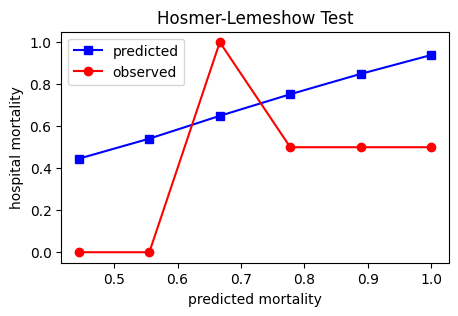

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 7/10 [00:07<00:03,  1.00s/it]

test AUROC: 0.7400
test Precision: 0.4167
test Recall: 1.0000
test Specificity: 0.2000
test Accuracy: 0.5333
test F1 Score: 0.5882
test HL Score: 17.7009
(165, 120, 12)
(165,)
tensor([2.0370, 1.9643])


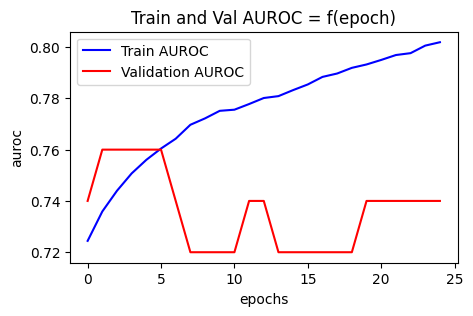

[       nan        nan        nan 0.         0.         0.
 0.28846154 0.75714286 0.34782609 0.52083333]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


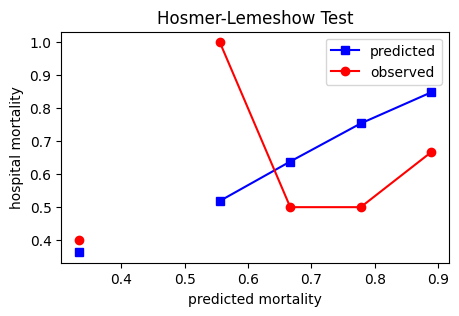

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8/10 [00:08<00:01,  1.00it/s]

test AUROC: 0.5357
test Precision: 0.6000
test Recall: 0.7500
test Specificity: 0.3333
test Accuracy: 0.6000
test F1 Score: 0.6667
test HL Score: 3.2763
(167, 120, 12)
(167,)
tensor([2.1139, 1.8977])


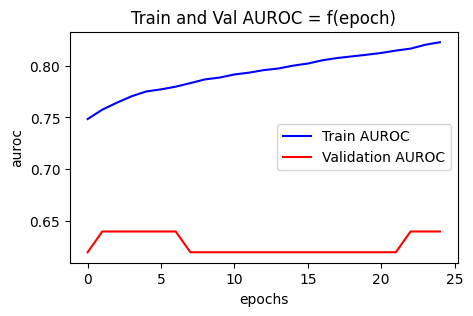

[       nan        nan 0.         0.22222222 0.24528302 0.38888889
 0.71794872 0.18       0.26595745 0.625     ]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


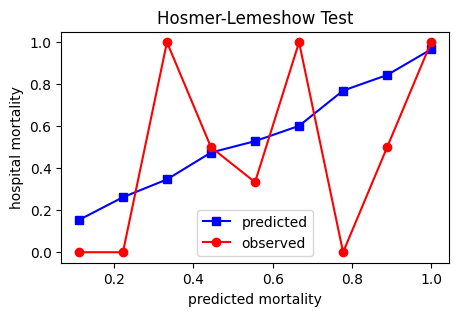

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9/10 [00:09<00:00,  1.00it/s]

test AUROC: 0.6852
test Precision: 0.4444
test Recall: 0.6667
test Specificity: 0.4000
test Accuracy: 0.5333
test F1 Score: 0.5333
test HL Score: 12.2376
(163, 120, 12)
(163,)
tensor([2.1169, 1.8953])


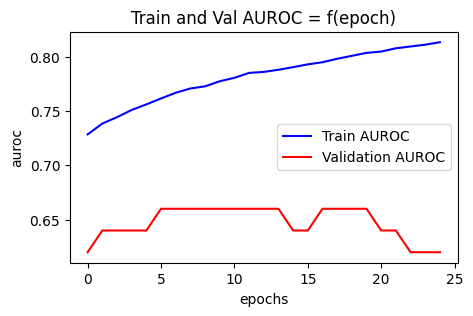

[       nan        nan 0.         0.13636364 0.13157895 0.45454545
 0.63793103 0.27777778 0.17475728 0.68085106]


/tmp/ipykernel_77775/3431086985.py:232: RuntimeWarning: invalid value encountered in divide
  mean_true = val_HL_true_groups/val_HL_num_groups
/tmp/ipykernel_77775/3431086985.py:270: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
/tmp/ipykernel_77775/3431086985.py:271: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.linspace(0,1,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')


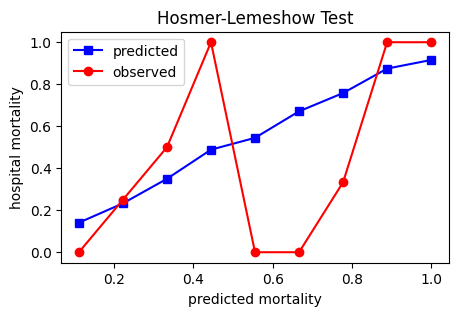

/tmp/ipykernel_77775/3431086985.py:280: RuntimeWarning: invalid value encountered in divide
  HL_score = np.nansum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.05s/it]

test AUROC: 0.7273
test Precision: 0.4000
test Recall: 0.5714
test Specificity: 0.4444
test Accuracy: 0.5000
test F1 Score: 0.4706
test HL Score: 11.2156
Mean AUROC: 0.7327
Mean Precision: 0.4208
Mean Recall: 0.8455
Mean Specificity: 0.2911
Mean Accuracy: 0.5233
Mean F1 Score: 0.5403
SD Auroc: 0.1225
Total Mean AUROC: 0.7260
Total Mean Precision: 0.4285
Total Mean Recall: 0.8548
Total Mean Specificity: 0.2987
Total Mean Accuracy: 0.5376
Total Mean F1 Score: 0.5479


NameError: name 'saved_results_folder' is not defined

In [24]:
num_train = 10
K = 10

save_path = "saved_models/save1.pth"
load_path = "saved_models/test.pth"


best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_mean = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []   

mean_fpr = np.linspace(0, 1, 100)
tprs = []
predictions_list = []
labels_list = []
aurocs_list = []

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []    
    
    for j in tqdm(range(10)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, best_val_auroc, state_dict, mean_true, predictions, true_labels = train_model(
                                                                                    data=data_ECMO,
                                                                                    target=target_ECMO,
                                                                                    test_fold = j,
                                                                                    validation_activated=True,
                                                                                    test_activated = True,
                                                                                    num_epochs=25, 
                                                                                    model_name="InceptionTime",
                                                                                    verbose=False, 
                                                                                    save_path=save_path, 
                                                                                    save_model=True, 
                                                                                    plot_train_curves = True,
                                                                                    load_model_path = load_path)
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        
        print(f"test AUROC: {auroc:.4f}")
        print(f"test Precision: {precision:.4f}")
        print(f"test Recall: {recall:.4f}")
        print(f"test Specificity: {tnr:.4f}")
        print(f"test Accuracy: {accuracy:.4f}")
        print(f"test F1 Score: {f1:.4f}")
        print(f"test HL Score: {HL_score:.4f}")
        
        fpr, tpr, _ = roc_curve(true_labels, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        predictions_list = predictions_list + list(predictions)
        labels_list = labels_list + list(true_labels)
        aurocs_list.append(auroc)
        
    print(f"Mean AUROC: {np.mean(aurocs):.4f}")
    print(f"Mean Precision: {np.mean(precisions):.4f}")
    print(f"Mean Recall: {np.mean(recalls):.4f}")
    print(f"Mean Specificity: {np.mean(tnrs):.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean F1 Score: {np.mean(f1s):.4f}")
    print(f"SD Auroc: {np.std(aurocs):.4f}")

    aurocs_mean.append(np.mean(aurocs))
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_mean):.4f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.4f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.4f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.4f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.4f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.4f}")



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)

list_to_save = [aurocs, mean_tpr, predictions_list, labels_list]

saved_results_folder = "./saved_results/"
saved_file_name = "InceptionTime_MR_Finetuned_On_ECMO_With_Augm"

with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
    pickle.dump(list_to_save, file)

In [25]:
saved_results_folder = "./saved_results/"
saved_file_name = "InceptionTime_MR_Finetuned_On_ECMO_With_Augm"

with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
    pickle.dump(list_to_save, file)